In [3]:
# !pip install convokit
# !pip install wordcloud
# !pip install --upgrade Pillow
# !pip install --upgrade pip 
# !pip install --upgrade Pillow
# !python -m pip install spacy-llm
# !python -m pip install spacy
# !pip install -U pip setuptools wheel
# !pip install -U spacy
#!python -m spacy download en_core_web_sm
# !pip install -U spacy[cuda113]
# !pip install -U spacy[cuda90]
# !pip install spacy_transformers
# !pip install accelerate
# !python -m spacy download en_core_web_trf

In [4]:

# Importar librerías

import re, os
import math
import pandas as pd
import numpy as np
import nltk
import json

from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from collections import Counter
import spacy
from spacy import displacy

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#Importación de keras y tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer

import os
import tensorflow_hub as hub

# Importar librerías para evaluar desempeño de los modelos
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

from huggingface_hub import hf_hub_download
from transformers import AutoModelForTokenClassification, pipeline
from accelerate import Accelerator

import plotly.express as px
import spacy
import torch
import torch.nn as nn
import transformers
torch.cuda.empty_cache()

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS




## Importar Datos

In [5]:
data_list = []
messages = []
with open('NLP_Diplomacy/train.jsonl', 'r') as archivo:
    for line in archivo:
        # Load each line as a JSON object
        try:
            data = json.loads(line)
            data_list.append(data)
            messages.extend(data['messages'])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

validation_list = []
messages = []
with open('NLP_Diplomacy/validation.jsonl', 'r') as archivo:
    for line in archivo:
        # Load each line as a JSON object
        try:
            validation = json.loads(line)
            validation_list.append(validation)
            messages.extend(validation['messages'])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            
test_list = []
messages = []
with open('NLP_Diplomacy/test.jsonl', 'r') as archivo:
    for line in archivo:
        # Load each line as a JSON object
        try:
            test = json.loads(line)
            test_list.append(validation)
            messages.extend(validation['messages'])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

## Convertir en DataFrame y Observar estructura de celdas

In [6]:
df_val = pd.DataFrame(validation_list)
df_val.head()

messages  \
0  [Good afternoon to our friends in the south, j...   
1  [How’s it going Italy?, Relatively well. I'm d...   
2  [Hello :). How goes the mighty Tsar?, Hi Italy...   
3  [Hows everyones favorite Geopolitical Powerhou...   
4  [And how is the mighty Sultan today?, I’m doin...   

                                       sender_labels  \
0  [True, True, True, True, True, True, True, Tru...   
1  [True, True, True, True, True, True, True, Tru...   
2  [True, True, True, True, True, True, True, Tru...   
3  [True, True, True, True, True, True, True, Tru...   
4  [True, True, True, True, True, True, True, Tru...   

                                     receiver_labels  \
0  [True, True, True, True, True, True, True, Tru...   
1  [True, True, True, True, True, True, True, Tru...   
2  [NOANNOTATION, True, NOANNOTATION, NOANNOTATIO...   
3  [True, True, True, True, True, True, True, Tru...   
4  [True, True, True, True, True, True, True, Tru...   

                                            speakers  \
0  [germany, italy, germany, italy, italy, italy,...   
1  [austria, italy, italy, italy, italy, austria,...   
2  [italy, russia, italy, italy, italy, italy, ru...   
3  [italy, england, england, italy, italy, italy,...   
4  [italy, turkey, italy, turkey, turkey, italy, ...   

                                           receivers  \
0  [italy, germany, italy, germany, germany, germ...   
1  [italy, austria, austria, austria, austria, it...   
2  [russia, italy, russia, russia, russia, russia...   
3  [england, italy, italy, england, england, engl...   
4  [turkey, italy, turkey, italy, italy, turkey, ...   

                              absolute_message_index  \
0  [6, 11, 14, 96, 97, 98, 99, 106, 121, 133, 137...   
1  [1, 3, 32, 34, 38, 45, 78, 88, 89, 100, 101, 1...   
2  [13, 64, 81, 82, 83, 84, 110, 112, 134, 135, 1...   
3  [33, 48, 49, 90, 91, 92, 93, 155, 193, 237, 31...   
4  [4, 16, 31, 36, 37, 39, 40, 94, 95, 104, 105, ...   

                              relative_message_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                             seasons  \
0  [Spring, Spring, Spring, Spring, Spring, Sprin...   
1  [Spring, Spring, Spring, Spring, Spring, Sprin...   
2  [Spring, Spring, Spring, Spring, Spring, Sprin...   
3  [Spring, Spring, Spring, Spring, Spring, Sprin...   
4  [Spring, Spring, Spring, Spring, Spring, Sprin...   

                                               years  \
0  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
1  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
2  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
3  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
4  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   

                                          game_score  \
0  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   
1  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   
2  [3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, ...   
3  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, ...   
4  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   

                                    game_score_delta           players  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [italy, germany]   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [italy, austria]   
2  [-1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -...   [italy, russia]   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [italy, england]   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   [italy, turkey]   

   game_id  
0       11  
1       11  
2       11  
3       11  
4       11

In [7]:
df_test = pd.DataFrame(test_list)
df_test.head()

messages  \
0  [Hey Turkey, how are you?, I’m doing great!! Y...   
1  [Hey Turkey, how are you?, I’m doing great!! Y...   
2  [Hey Turkey, how are you?, I’m doing great!! Y...   
3  [Hey Turkey, how are you?, I’m doing great!! Y...   
4  [Hey Turkey, how are you?, I’m doing great!! Y...   

                                       sender_labels  \
0  [True, True, True, True, False, True, True, Tr...   
1  [True, True, True, True, False, True, True, Tr...   
2  [True, True, True, True, False, True, True, Tr...   
3  [True, True, True, True, False, True, True, Tr...   
4  [True, True, True, True, False, True, True, Tr...   

                                     receiver_labels  \
0  [True, True, True, True, True, True, True, Tru...   
1  [True, True, True, True, True, True, True, Tru...   
2  [True, True, True, True, True, True, True, Tru...   
3  [True, True, True, True, True, True, True, Tru...   
4  [True, True, True, True, True, True, True, Tru...   

                                            speakers  \
0  [france, turkey, france, turkey, france, turke...   
1  [france, turkey, france, turkey, france, turke...   
2  [france, turkey, france, turkey, france, turke...   
3  [france, turkey, france, turkey, france, turke...   
4  [france, turkey, france, turkey, france, turke...   

                                           receivers  \
0  [turkey, france, turkey, france, turkey, franc...   
1  [turkey, france, turkey, france, turkey, franc...   
2  [turkey, france, turkey, france, turkey, franc...   
3  [turkey, france, turkey, france, turkey, franc...   
4  [turkey, france, turkey, france, turkey, franc...   

                              absolute_message_index  \
0  [26, 35, 273, 285, 307, 325, 350, 1041, 1119, ...   
1  [26, 35, 273, 285, 307, 325, 350, 1041, 1119, ...   
2  [26, 35, 273, 285, 307, 325, 350, 1041, 1119, ...   
3  [26, 35, 273, 285, 307, 325, 350, 1041, 1119, ...   
4  [26, 35, 273, 285, 307, 325, 350, 1041, 1119, ...   

                              relative_message_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                             seasons  \
0  [Spring, Spring, Fall, Fall, Fall, Winter, Win...   
1  [Spring, Spring, Fall, Fall, Fall, Winter, Win...   
2  [Spring, Spring, Fall, Fall, Fall, Winter, Win...   
3  [Spring, Spring, Fall, Fall, Fall, Winter, Win...   
4  [Spring, Spring, Fall, Fall, Fall, Winter, Win...   

                                               years  \
0  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
1  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
2  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
3  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
4  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   

                                      game_score  \
0  [3, 3, 3, 3, 3, 4, 6, 6, 8, 8, 8, 8, 8, 8, 6]   
1  [3, 3, 3, 3, 3, 4, 6, 6, 8, 8, 8, 8, 8, 8, 6]   
2  [3, 3, 3, 3, 3, 4, 6, 6, 8, 8, 8, 8, 8, 8, 6]   
3  [3, 3, 3, 3, 3, 4, 6, 6, 8, 8, 8, 8, 8, 8, 6]   
4  [3, 3, 3, 3, 3, 4, 6, 6, 8, 8, 8, 8, 8, 8, 6]   

                                   game_score_delta           players  game_id  
0  [0, 0, 0, 0, 0, -2, 2, -2, 2, 2, 2, 2, 2, 2, -2]  [turkey, france]       11  
1  [0, 0, 0, 0, 0, -2, 2, -2, 2, 2, 2, 2, 2, 2, -2]  [turkey, france]       11  
2  [0, 0, 0, 0, 0, -2, 2, -2, 2, 2, 2, 2, 2, 2, -2]  [turkey, france]       11  
3  [0, 0, 0, 0, 0, -2, 2, -2, 2, 2, 2, 2, 2, 2, -2]  [turkey, france]       11  
4  [0, 0, 0, 0, 0, -2, 2, -2, 2, 2, 2, 2, 2, 2, -2]  [turkey, france]       11

In [8]:
# Crear un DataFrame con los datos
df = pd.DataFrame(data_list)
df.head()

messages  \
0  [Germany!\n\nJust the person I want to speak w...   
1  [Hello there! What's your general plan for thi...   
2  [Buongiorno! \nBe kinda nice to know if you're...   
3  [Hey italy! good luck this game. I'm guessing ...   
4  [Hello Italy what’s up what are your thoughts ...   

                                       sender_labels  \
0  [True, True, True, True, True, True, True, Tru...   
1  [True, False, True, False, True, True, True, T...   
2  [True, True, False, True, True, True, True, Tr...   
3  [True, False, True, True, True, True, True, Tr...   
4  [True, False, False, True, True, True, True, T...   

                                     receiver_labels  \
0  [True, True, True, True, NOANNOTATION, NOANNOT...   
1  [True, True, True, True, True, NOANNOTATION, T...   
2  [True, False, True, False, True, True, NOANNOT...   
3  [NOANNOTATION, True, True, False, True, True, ...   
4  [NOANNOTATION, True, True, True, True, True, N...   

                                            speakers  \
0  [italy, germany, italy, germany, italy, italy,...   
1  [austria, italy, austria, italy, italy, austri...   
2  [russia, italy, russia, italy, russia, italy, ...   
3  [england, italy, england, england, england, it...   
4  [turkey, italy, italy, italy, turkey, italy, t...   

                                           receivers  \
0  [germany, italy, germany, italy, germany, germ...   
1  [italy, austria, italy, austria, austria, ital...   
2  [italy, russia, italy, russia, italy, russia, ...   
3  [italy, england, italy, italy, italy, england,...   
4  [italy, turkey, turkey, turkey, italy, turkey,...   

                              absolute_message_index  \
0  [74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...   
1  [1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...   
2  [11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...   
3  [32, 95, 106, 107, 108, 110, 113, 125, 126, 12...   
4  [45, 94, 103, 150, 154, 178, 192, 194, 195, 19...   

                              relative_message_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                             seasons  \
0  [Spring, Spring, Spring, Spring, Spring, Sprin...   
1  [Spring, Spring, Spring, Spring, Spring, Sprin...   
2  [Spring, Spring, Spring, Spring, Spring, Sprin...   
3  [Spring, Spring, Spring, Spring, Spring, Sprin...   
4  [Spring, Spring, Spring, Spring, Fall, Fall, F...   

                                               years  \
0  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
1  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
2  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
3  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   
4  [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...   

                                          game_score  \
0  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   
1  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...   
2  [4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...   
3  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...   
4  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...   

                                    game_score_delta           players  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [italy, germany]   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...  [italy, austria]   
2  [1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...   [italy, russia]   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [italy, england]   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...   [italy, turkey]   

   game_id  
0        1  
1        1  
2        1  
3        1  
4        1

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                189 non-null    object
 1   sender_labels           189 non-null    object
 2   receiver_labels         189 non-null    object
 3   speakers                189 non-null    object
 4   receivers               189 non-null    object
 5   absolute_message_index  189 non-null    object
 6   relative_message_index  189 non-null    object
 7   seasons                 189 non-null    object
 8   years                   189 non-null    object
 9   game_score              189 non-null    object
 10  game_score_delta        189 non-null    object
 11  players                 189 non-null    object
 12  game_id                 189 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 19.3+ KB


### Se hace explode a los valores de las celdas para sacar facilitar el trabajo con el DataFrame

In [10]:

df_explode=df.explode(['messages',
 'sender_labels',
 'receiver_labels',
 'speakers',
 'receivers',
 'absolute_message_index',
 'relative_message_index',
 'seasons',
 'years',
 'game_score',
 'game_score_delta'
 ], ignore_index=True)

df_val=df_val.explode(['messages',
 'sender_labels',
 'receiver_labels',
 'speakers',
 'receivers',
 'absolute_message_index',
 'relative_message_index',
 'seasons',
 'years',
 'game_score',
 'game_score_delta'
 ], ignore_index=True)

df_test=df_test.explode(['messages',
 'sender_labels',
 'receiver_labels',
 'speakers',
 'receivers',
 'absolute_message_index',
 'relative_message_index',
 'seasons',
 'years',
 'game_score',
 'game_score_delta'
 ], ignore_index=True)

In [11]:
# Se valida el resultado
df_explode.head(2)

messages sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...          True   
1  You've whet my appetite, Italy. What's the sug...          True   

  receiver_labels speakers receivers absolute_message_index  \
0            True    italy   germany                     74   
1            True  germany     italy                     76   

  relative_message_index seasons years game_score game_score_delta  \
0                      0  Spring  1901          3                0   
1                      1  Spring  1901          3                0   

            players  game_id  
0  [italy, germany]        1  
1  [italy, germany]        1

In [12]:
# Se obserba las nuevas dimensiones del DataFrame
df_explode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13137 entries, 0 to 13136
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                13132 non-null  object
 1   sender_labels           13132 non-null  object
 2   receiver_labels         13132 non-null  object
 3   speakers                13132 non-null  object
 4   receivers               13132 non-null  object
 5   absolute_message_index  13132 non-null  object
 6   relative_message_index  13132 non-null  object
 7   seasons                 13132 non-null  object
 8   years                   13132 non-null  object
 9   game_score              13132 non-null  object
 10  game_score_delta        13132 non-null  object
 11  players                 13137 non-null  object
 12  game_id                 13137 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 1.3+ MB


In [13]:
# Se obserba las nuevas dimensiones del DataFrame
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417 entries, 0 to 1416
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                1416 non-null   object
 1   sender_labels           1416 non-null   object
 2   receiver_labels         1416 non-null   object
 3   speakers                1416 non-null   object
 4   receivers               1416 non-null   object
 5   absolute_message_index  1416 non-null   object
 6   relative_message_index  1416 non-null   object
 7   seasons                 1416 non-null   object
 8   years                   1416 non-null   object
 9   game_score              1416 non-null   object
 10  game_score_delta        1416 non-null   object
 11  players                 1417 non-null   object
 12  game_id                 1417 non-null   int64 
dtypes: int64(1), object(12)
memory usage: 144.0+ KB


In [14]:
# Se obserba las nuevas dimensiones del DataFrame
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                630 non-null    object
 1   sender_labels           630 non-null    object
 2   receiver_labels         630 non-null    object
 3   speakers                630 non-null    object
 4   receivers               630 non-null    object
 5   absolute_message_index  630 non-null    object
 6   relative_message_index  630 non-null    object
 7   seasons                 630 non-null    object
 8   years                   630 non-null    object
 9   game_score              630 non-null    object
 10  game_score_delta        630 non-null    object
 11  players                 630 non-null    object
 12  game_id                 630 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 64.1+ KB


## Analisis Exploratorio de Datos

### Funciones para exploracion de datos y manejo de la calidad de datos

In [15]:
def analyze_and_plot_sentiment(df, messages_clean_column, y1, y2):
    """
    Esta función realiza un análisis de sentimientos y genera gráficos basados en los resultados.

    Parámetros:
    df (pandas.DataFrame): DataFrame que contiene los datos a analizar.
    messages_clean_column (str): Nombre de la columna en df que contiene los mensajes limpios.
    y1 (str): Nombre de la columna en df que contiene las etiquetas de sentimiento.
    y2 (str): Nombre de la columna en df que contiene las etiquetas del hablante.

    La función realiza las siguientes operaciones:
    1. Calcula la proporción de publicaciones para cada sentimiento.
    2. Crea una nueva columna con el número de caracteres en cada publicación.
    3. Genera un gráfico de la cantidad de publicaciones según el sentimiento.
    4. Genera un gráfico de la cantidad de publicaciones para cada hablante según el sentimiento.
    """

    # Calculate the proportion of publications for each sentiment
    sender_labels_information = df.sender_labels.unique().tolist()
    for info in sender_labels_information:
        proportion = df[df[y1] == info].shape[0] / df.shape[0]
        print(f'Proporción de publicaciones con info {info}: {proportion}')

    # Create a column with the number of characters in the publication
    df['caracteres_texto'] = df[messages_clean_column].apply(lambda row: len(str(row)) if not pd.isna(row) else np.nan)

    # Plot the count of publications according to sentiment
    sns.catplot(data=df, y=y1, kind="count")
    plt.show()

    # Plot the count of publications for each speaker according to sentiment
    sns.catplot(data=df, y=y2, hue=y1, kind="count")
    plt.show()


def plot_character_count(df, x_col, y_col, hue_col=None):
    """
    Esta función genera un gráfico de violín del recuento de caracteres para diferentes categorías.

    Parámetros:
    df (pandas.DataFrame): DataFrame que contiene los datos a analizar.
    x_col (str): Nombre de la columna en df que se utilizará en el eje x del gráfico.
    y_col (str): Nombre de la columna en df que se utilizará en el eje y del gráfico.
    hue_col (str, opcional): Nombre de la columna en df que se utilizará para colorear los datos. Por defecto es None.

    La función realiza las siguientes operaciones:
    1. Configura la figura del gráfico.
    2. Genera un gráfico de violín de los datos.
    3. Añade etiquetas y título al gráfico.
    4. Muestra el gráfico.
    """

    # Set up the figure
    plt.figure(figsize=(12, 6))
    
    # Violin plot for the first condition
    sns.violinplot(x=x_col, y=y_col, hue=hue_col, data=df)
    
    # Add labels and title
    plt.xlabel(x_col.capitalize())
    plt.ylabel("Character Count")
    plt.title(f"Violin Plot of Character Count for {x_col.capitalize()}")
    
    # Show the plot
    plt.show()


def generate_wordcloud(dataframe, column_name):
    """
    Esta función genera una nube de palabras a partir de los datos de una columna específica de un DataFrame.

    Parámetros:
    dataframe (pandas.DataFrame): DataFrame que contiene los datos a analizar.
    column_name (str): Nombre de la columna en dataframe de la cual se generarán las palabras para la nube.

    La función realiza las siguientes operaciones:
    1. Concatena todos los mensajes en una sola cadena de texto.
    2. Genera la nube de palabras con la ruta de la fuente especificada.
    3. Genera una imagen de la nube de palabras.
    4. Muestra la imagen de la nube de palabras.
    """

    # Concatenate all messages into a single string
    text = ' '.join(dataframe[column_name].astype(str))

    # Generate WordCloud with font_path specified
    wcloud = WordCloud(width=700, height=300, background_color="white", font_path=WordCloud().font_path).generate(text)

    # Plot the WordCloud image                        
    plt.figure(figsize=(5, 3), dpi=200)
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


def plot_top_words_frequency(dataframe, column, top_n=50):
    """
    Esta función genera un gráfico de barras de la frecuencia de las palabras más comunes en una columna específica de un DataFrame.

    Parámetros:
    dataframe (pandas.DataFrame): DataFrame que contiene los datos a analizar.
    column (str): Nombre de la columna en dataframe de la cual se generarán las palabras para el gráfico.
    top_n (int, opcional): Número de palabras más comunes a mostrar en el gráfico. Por defecto es 50.

    La función realiza las siguientes operaciones:
    1. Concatena todas las palabras en la columna especificada.
    2. Tokeniza las palabras.
    3. Cuenta la frecuencia de cada palabra.
    4. Obtiene las palabras más frecuentes.
    5. Crea un gráfico de barras de las palabras más frecuentes.
    """

    # Concatenar todas las palabras en la columna
    all_words = ' '.join(dataframe[column].astype(str).values)

    # Tokenizar las palabras
    words = all_words.split()

    # Contar la frecuencia de cada palabra
    word_freq = Counter(words)

    # Obtener las palabras más frecuentes
    top_words = dict(word_freq.most_common(top_n))

    # Crear un gráfico de barras
    plt.figure(figsize=(20, 15))
    sns.barplot(x=list(top_words.keys()), y=list(top_words.values()))
    plt.title(f'Top {top_n} Palabras Más Frecuentes')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=90, ha='right')
    plt.show()

    
def plot_and_average_text_length(df):
    """
    Esta función genera un histograma de la distribución del número de caracteres en el texto y calcula el promedio del número de caracteres.

    Parámetros:
    df (pandas.DataFrame): DataFrame que contiene los datos a analizar. Se asume que df tiene una columna llamada 'caracteres_texto' que contiene el número de caracteres en el texto.

    La función realiza las siguientes operaciones:
    1. Genera un histograma de la distribución del número de caracteres en el texto.
    2. Calcula el promedio del número de caracteres en el texto.
    """

    # Graficar la distribución del número de caracteres en el texto
    plt.figure(figsize=(10, 6))
    plt.hist(df['caracteres_texto'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribución del Número de Caracteres en el Texto')
    plt.xlabel('Número de Caracteres')
    plt.ylabel('Frecuencia')
    plt.show()

    # Calcular el promedio del número de caracteres en el texto
    average_length = df['caracteres_texto'].mean()
    print(f'Promedio del número de caracteres en el texto: {average_length:.2f}')

    
def remove_nan_rows(dataframe, columns=['messages', 'sender_labels', 'receiver_labels']):
    """
    Elimina las filas con valores NaN en las columnas especificadas.

    Parámetros:
    - dataframe (pandas.DataFrame): DataFrame a procesar.
    - columns (list, opcional): Lista de columnas para verificar los valores NaN. Por defecto es ['messages', 'sender_labels', 'receiver_labels'].

    Devuelve:
    - pandas.DataFrame: DataFrame con las filas que contienen valores NaN eliminadas.
    """
    return dataframe.dropna(subset=columns)


def remove_tags(string, remove_special_chars=False, remove_stopwords=False, remove_newlines=False):
    """
    Esta función elimina varios tipos de contenido no deseado de una cadena de texto.

    Parámetros:
    - string (str): Cadena de texto a procesar.
    - remove_special_chars (bool, opcional): Si es True, se eliminan los caracteres no alfanuméricos. Por defecto es False.
    - remove_stopwords (bool, opcional): Si es True, se eliminan las palabras vacías en inglés. Por defecto es False.
    - remove_newlines (bool, opcional): Si es True, se eliminan los caracteres de nueva línea. Por defecto es False.

    La función realiza las siguientes operaciones:
    1. Elimina las etiquetas HTML.
    2. Elimina los nombres de usuario de Twitter.
    3. Elimina los hashtags.
    4. Elimina los números.
    5. Elimina las URLs.
    6. Si remove_special_chars es True, elimina los caracteres no alfanuméricos.
    7. Si remove_newlines es True, elimina los caracteres de nueva línea y los espacios extra.
    8. Si remove_stopwords es True, elimina las palabras vacías en inglés.
    9. Elimina las palabras de longitud 1.
    10. Convierte la cadena a minúsculas.

    Devuelve:
    - str: Cadena de texto procesada.
    """
    result = re.sub(r'<.*?>', '', string)  # Remove HTML tags
    result = re.sub('@[\w]+', '', result)  # Remove Twitter usernames
    result = re.sub('#[\w]+', '', result)  # Remove hashtags
    result = re.sub("\d+", " ", result)  # Remove numbers
    result = re.sub(r'http\S+', '', result)  # Remove URLs

    if remove_special_chars:
        result = re.sub(r'[^\w\s]', ' ', result)  # Remove non-alphanumeric characters

    if remove_newlines:
        result = re.sub(r'\n\n', ' ', result)  # Remove newline characters
        result = ' '.join(result.split())  # Split and join to remove extra spaces

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        result = ' '.join([w for w in result.split() if w.lower() not in stop_words])

    # Remove words of length 1
    result = ' '.join([word for word in result.split() if len(word) > 1])

    result = result.lower()
    return result


def create_tfidf_column(df, text_column, max_keywords=5):
    """
    Crea una columna TF-IDF y columnas de resumen de patrones clave para cada celda en el DataFrame.

    Parámetros:
    - df (pandas.DataFrame): DataFrame que contiene los datos de texto.
    - text_column (str): Nombre de la columna que contiene los datos de texto.
    - max_keywords (int, opcional): Número máximo de palabras clave para extraer para el resumen. Por defecto es 5.

    Devuelve:
    - pandas.DataFrame: DataFrame con columnas adicionales para TF-IDF y resúmenes de patrones clave.

    La función realiza las siguientes operaciones:
    1. Crea una copia del DataFrame para evitar modificar el original.
    2. Crea un vectorizador TF-IDF.
    3. Ajusta y transforma los datos de texto.
    4. Reinicia el índice para un indexado adecuado.
    5. Añade la matriz TF-IDF al DataFrame como una nueva columna.
    6. Extrae patrones clave usando la similitud del coseno para textos más similares.
    7. Extrae patrones clave usando la similitud del coseno para textos menos similares.
    8. Añade las columnas de resumen de patrones clave al DataFrame.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, max_features=5000)
    
    # Fit and transform the text data
    tfidf_matrix = vectorizer.fit_transform(df[text_column])

    # Reset index for proper indexing
    df.reset_index(drop=True, inplace=True)

    # Add the TF-IDF matrix to the DataFrame as a new column
    df['tfidf'] = list(tfidf_matrix.toarray())

    # Extract key patterns using cosine similarity for more similar texts
    summary_more_similar = []
    for i in range(len(df)):
        similarity_matrix = cosine_similarity(tfidf_matrix[i], tfidf_matrix)
        top_similar_indices = similarity_matrix.argsort()[0][-max_keywords-1:-1]
        top_similar_texts = df.loc[top_similar_indices, text_column].tolist()
        summary_more_similar.append(", ".join(top_similar_texts))

    # Extract key patterns using cosine similarity for less similar texts
    summary_less_similar = []
    for i in range(len(df)):
        similarity_matrix = cosine_similarity(tfidf_matrix[i], tfidf_matrix)
        less_similar_indices = similarity_matrix.argsort()[0][:max_keywords]
        less_similar_texts = df.loc[less_similar_indices, text_column].tolist()
        summary_less_similar.append(", ".join(less_similar_texts))

    # Add the key pattern summary columns to the DataFrame
    df['summary_more_similar'] = summary_more_similar
    df['summary_less_similar'] = summary_less_similar

    return df


def create_tfidf_column(df, text_column, max_keywords=5):
    """
    Crea una columna TF-IDF y una columna de resumen de patrones clave para cada celda en el DataFrame.

    Parámetros:
    - df: DataFrame que contiene los datos de texto.
    - text_column: Nombre de la columna que contiene los datos de texto.
    - max_keywords: Número máximo de palabras clave a extraer para el resumen.

    Retorna:
    - df: DataFrame con columnas adicionales para TF-IDF y resúmenes de patrones clave.
    """
    # Crear una copia del DataFrame para evitar modificar el original
    df = df.copy()

    # Crear un vectorizador TF-IDF
    vectorizador = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, max_features=5000)
    
    # Ajustar y transformar los datos de texto
    matriz_tfidf = vectorizador.fit_transform(df[text_column])

    # Restablecer el índice para un indexado adecuado
    df.reset_index(drop=True, inplace=True)

    # Agregar la matriz TF-IDF al DataFrame como una nueva columna
    df['tfidf'] = list(matriz_tfidf.toarray())

    # Extraer patrones clave utilizando la similitud del coseno
    resumen = []
    for i in range(len(df)):
        matriz_similitud = cosine_similarity(matriz_tfidf[i], matriz_tfidf)
        indices_similares_superiores = matriz_similitud.argsort()[0][-max_keywords-1:-1]
        textos_similares_superiores = df.loc[indices_similares_superiores, text_column].tolist()
        resumen.append(", ".join(textos_similares_superiores))

    # Agregar la columna de resumen de patrones clave al DataFrame
    df['summary'] = resumen

    return df


def filter_and_count_keywords(df, keywords):
    """
    Filtra un DataFrame basado en la presencia de todas las palabras clave en la columna 'summary_more_similar' y cuenta las filas.

    Parámetros:
    - df: DataFrame a filtrar.
    - keywords: Lista de palabras clave para verificar en la columna 'summary_more_similar'.

    Retorna:
    - filtered_df: DataFrame que contiene las filas donde 'summary_more_similar' contiene todas las palabras clave.
    - num_rows: Número de filas en el DataFrame filtrado.
    """
    # Crear una copia del DataFrame para evitar modificar el original
    df = df.copy()

    # Filtrar filas basadas en la presencia de todas las palabras clave en 'summary_more_similar'
    filtered_df = df[df['summary_more_similar'].apply(lambda x: all(keyword.lower() in x.lower() for keyword in keywords))]

    # Realizar una operación de distintos en el DataFrame filtrado
    filtered_df = filtered_df.drop_duplicates(subset=['summary_more_similar'])

    # Obtener el número de filas en el DataFrame filtrado
    num_rows = len(filtered_df)

    return filtered_df, num_rows


### Analisis de Total de clases de mentiras y verdades

Proporción de publicaciones con info True: 0.9546319555454061
Proporción de publicaciones con info False: 0.04498744005480703
Proporción de publicaciones con info nan: 0.0


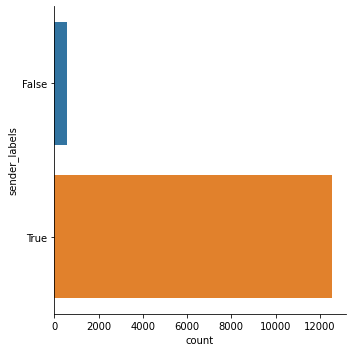

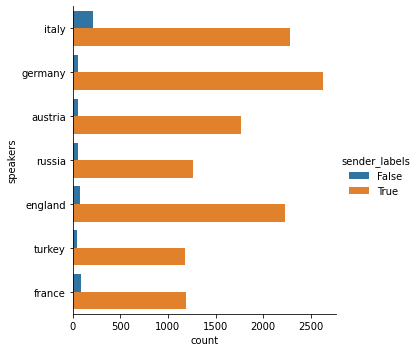

In [16]:

analyze_and_plot_sentiment(df_explode, 'messages','sender_labels',"speakers")

In [17]:
# Los datos estan con un imbalanceo muy marcado lo que dificultara la tarea para la implementacion del modelo, 
# es necesario segur analizando para gestionar mejores estrategias para afrontar los datos

Proporción de publicaciones con info True: 0.8722691634315293
Proporción de publicaciones con info False: 0.04308441805587272
Proporción de publicaciones con info nan: 0.0


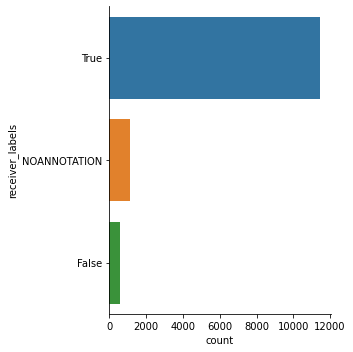

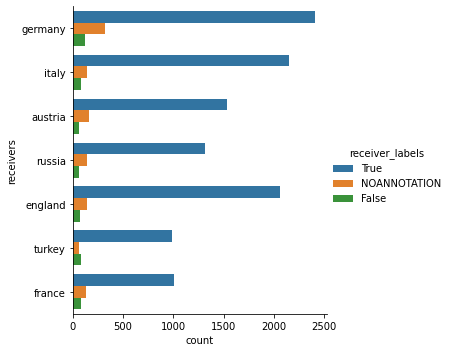

In [18]:
analyze_and_plot_sentiment(df_explode, 'messages','receiver_labels',"receivers")

Proporción de coincidencia: 0.8406789982492198
Proporción de no coincidencia: 0.15932100175078023


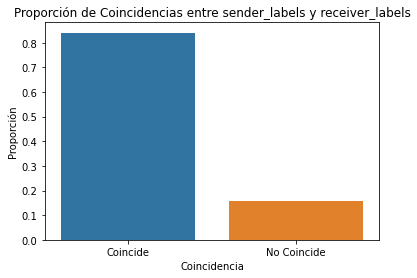

In [19]:

df_explode['coincide'] = df_explode['sender_labels'] == df_explode['receiver_labels']

# Calcular la proporción de coincidencias
proporcion_coincidencia = df_explode['coincide'].mean()
print('Proporción de coincidencia:', proporcion_coincidencia)
proporcion_no_coincidencia = 1 - proporcion_coincidencia
print('Proporción de no coincidencia:', proporcion_no_coincidencia)

# Gráfica
sns.barplot(x=['Coincide', 'No Coincide'], y=[proporcion_coincidencia, proporcion_no_coincidencia])
plt.title('Proporción de Coincidencias entre sender_labels y receiver_labels')
plt.xlabel('Coincidencia')
plt.ylabel('Proporción')
plt.show()


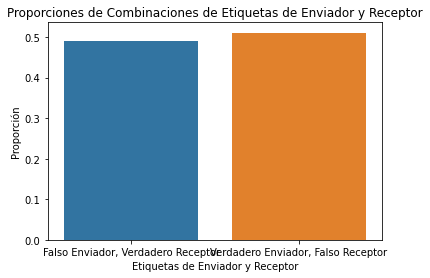

Proporción de Falso Enviador, Verdadero Receptor: 48.93%
Proporción de Verdadero Enviador, Falso Receptor: 51.07%


In [21]:
# Se filtra el df con el fin de entender cuando hay mentiras o por el contrario desconfianza del receptor
filtered_df = df_explode[(df_explode['sender_labels'] == False) & (df_explode['receiver_labels'] == True) | 
                 (df_explode['sender_labels'] == True) & (df_explode['receiver_labels'] == False)]

# Calcular las proporciones
proporcion_falso_env_verd_recep = (filtered_df['sender_labels'] == False).mean()
proporcion_verd_env_falso_recep = (filtered_df['receiver_labels'] == False).mean()

# Gráfica
sns.barplot(x=['Falso Enviador, Verdadero Receptor', 'Verdadero Enviador, Falso Receptor'],
            y=[proporcion_falso_env_verd_recep, proporcion_verd_env_falso_recep])
plt.title('Proporciones de Combinaciones de Etiquetas de Enviador y Receptor')
plt.xlabel('Etiquetas de Enviador y Receptor')
plt.ylabel('Proporción')
plt.show()

# Imprimir las proporciones
print(f'Proporción de Falso Enviador, Verdadero Receptor: {proporcion_falso_env_verd_recep:.2%}')
print(f'Proporción de Verdadero Enviador, Falso Receptor: {proporcion_verd_env_falso_recep:.2%}')


In [ ]:
# Se concluye que hay mas desconfianza que mentiras, por un porcentaje pequeno, esto evidencia la dinamica del juego
# y la dificultad del receptor de clasificar bien el mensaje

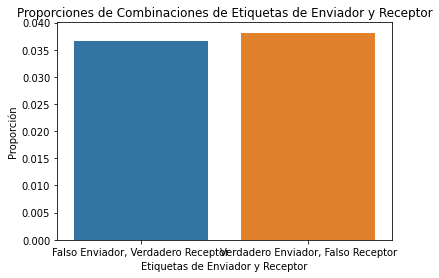

Proporción de Falso Enviador, Verdadero Receptor: 3.65%
Proporción de Verdadero Enviador, Falso Receptor: 3.81%


In [22]:
# Se filtra el df con el fin de entender cuando hay mentiras o por el contrario desconfianza del receptor
filtered_df = df_explode[(df_explode['sender_labels'] == False) & (df_explode['receiver_labels'] == True) | 
                 (df_explode['sender_labels'] == True) & (df_explode['receiver_labels'] == False)]

# Calcular el número total de celdas en las columnas especificadas
total_celdas = len(df_explode)

# Calcular las proporciones
proporcion_falso_enviador_verdadero_receptor = (filtered_df['sender_labels'] == False).sum() / total_celdas
proporcion_verdadero_enviador_falso_receptor = (filtered_df['receiver_labels'] == False).sum() / total_celdas

# Gráfica
sns.barplot(x=['Falso Enviador, Verdadero Receptor', 'Verdadero Enviador, Falso Receptor'],
            y=[proporcion_falso_enviador_verdadero_receptor, proporcion_verdadero_enviador_falso_receptor])
plt.title('Proporciones de Combinaciones de Etiquetas de Enviador y Receptor')
plt.xlabel('Etiquetas de Enviador y Receptor')
plt.ylabel('Proporción')
plt.show()

# Imprimir las proporciones
print(f'Proporción de Falso Enviador, Verdadero Receptor: {proporcion_falso_enviador_verdadero_receptor:.2%}')
print(f'Proporción de Verdadero Enviador, Falso Receptor: {proporcion_verdadero_enviador_falso_receptor:.2%}')


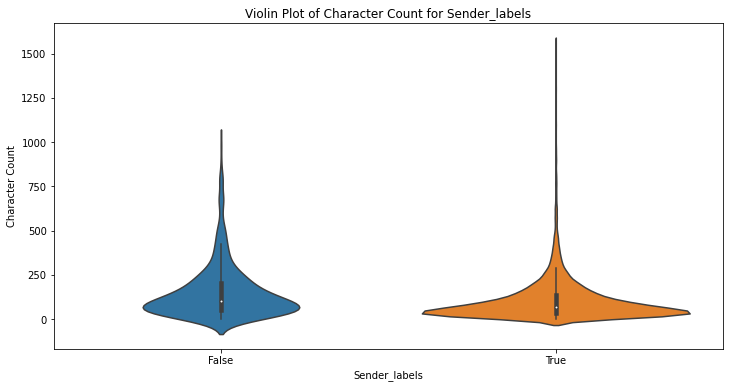

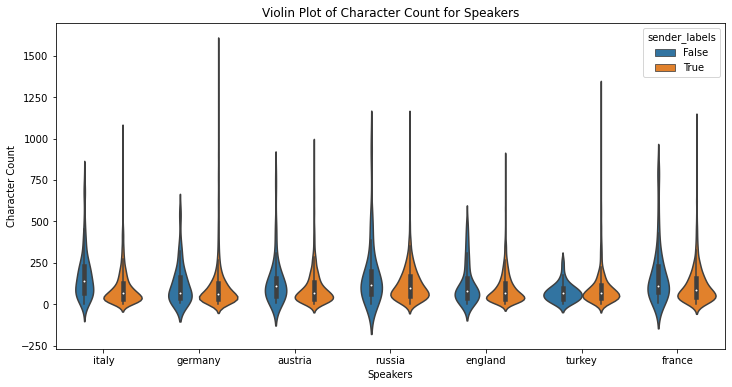

In [23]:
plot_character_count(df_explode, x_col='sender_labels', y_col='caracteres_texto')
plot_character_count(df_explode, x_col='speakers', y_col='caracteres_texto', hue_col='sender_labels')

In [23]:
# Se cuenta la cantidad de palabras que tienen los mensajes falsos y los mensajes verdaderos, se observa de manera
# genera y por pais, donde se evidencia que en general las verdades y las mentiras tiene una media de palabras similar,
# sin embarco en las verdades se nota una mayor densidad de mensajes cortos ciertos que falsos cortos, esto nos da
# indicios para saber en que tipos de mensajes nos podemos concentrar. 

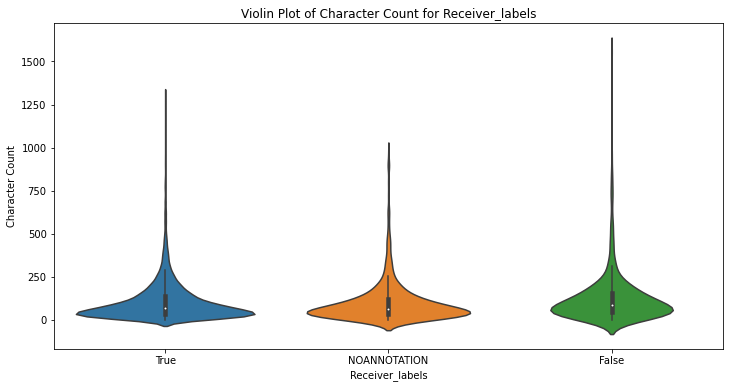

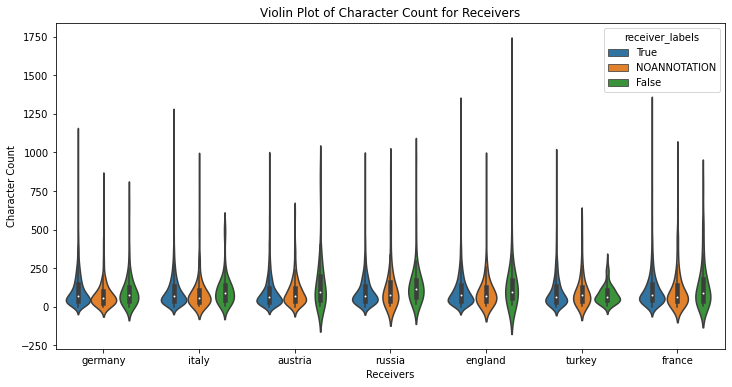

In [24]:
plot_character_count(df_explode, x_col='receiver_labels', y_col='caracteres_texto')
plot_character_count(df_explode, x_col='receivers', y_col='caracteres_texto', hue_col='receiver_labels')


In [ ]:
# Se nota en las distribuciones y los diagramas que generalmente los mensajes que toma como falso los receptores son cortos,
# en contraste con las verdaderas, es ratifica la conclusion anterior.

In [25]:
fig = px.histogram(df_explode, x="game_score", nbins=20, marginal="rug", title='Histograma de Puntuación del Juego')


fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            x=1.15,
            y=1.1,
            showactive=True,
            buttons=[
                dict(label="Todos",
                     method="relayout",
                     args=["xaxis.range", [None, None]]),
                *[
                    dict(label=f"Filtrar por {speaker}",
                         method="relayout",
                         args=["xaxis.range", [df_explode[df_explode['speakers'] == speaker]['game_score'].astype(float).min(),
                                              df_explode[df_explode['speakers'] == speaker]['game_score'].astype(float).max()]])
                    for speaker in df_explode['speakers'].unique()
                ]
            ],
        ),
        dict(
            type="dropdown",
            x=1.25,
            y=1.1,
            showactive=True,
            buttons=[
                dict(label="Todos",
                     method="relayout",
                     args=["xaxis.range", [None, None]]),
                *[
                    dict(label=f"Filtrar por {receiver}",
                         method="relayout",
                         args=["xaxis.range", [df_explode[df_explode['receivers'] == receiver]['game_score'].astype(float).min(),
                                              df_explode[df_explode['receivers'] == receiver]['game_score'].astype(float).max()]])
                    for receiver in df_explode['receivers'].unique()
                ]
            ],
        ),
    ]
)

# Show the plot
fig.show()



In [26]:
fig = px.histogram(df_explode, x="game_score", nbins=20, marginal="rug", title='Histograma de Puntuación del Juego')


fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            x=1.15,
            y=1.1,
            showactive=True,
            buttons=[
                dict(label="Todos",
                     method="relayout",
                     args=["xaxis.range", [None, None]]),
                *[
                    dict(label=f"Filtrar por {speaker} (sender_labels True)",
                         method="relayout",
                         args=["xaxis.range", [df_explode[(df_explode['speakers'] == speaker) & (df_explode['sender_labels'] == True)]['game_score'].astype(float).min(),
                                              df_explode[(df_explode['speakers'] == speaker) & (df_explode['sender_labels'] == True)]['game_score'].astype(float).max()]])
                    for speaker in df_explode['speakers'].unique()
                ],
                *[
                    dict(label=f"Filtrar por {speaker} (sender_labels False)",
                         method="relayout",
                         args=["xaxis.range", [df_explode[(df_explode['speakers'] == speaker) & (df_explode['sender_labels'] == False)]['game_score'].astype(float).min(),
                                              df_explode[(df_explode['speakers'] == speaker) & (df_explode['sender_labels'] == False)]['game_score'].astype(float).max()]])
                    for speaker in df_explode['speakers'].unique()
                ]
            ],
        ),
        dict(
            type="dropdown",
            x=1.25,
            y=1.1,
            showactive=True,
            buttons=[
                dict(label="Todos",
                     method="relayout",
                     args=["xaxis.range", [None, None]]),
                *[
                    dict(label=f"Filtrar por {receiver} (receiver_labels True)",
                         method="relayout",
                         args=["xaxis.range", [df_explode[(df_explode['receivers'] == receiver) & (df_explode['receiver_labels'] == True)]['game_score'].astype(float).min(),
                                              df_explode[(df_explode['receivers'] == receiver) & (df_explode['receiver_labels'] == True)]['game_score'].astype(float).max()]])
                    for receiver in df_explode['receivers'].unique()
                ],
                *[
                    dict(label=f"Filtrar por {receiver} (receiver_labels False)",
                         method="relayout",
                         args=["xaxis.range", [df_explode[(df_explode['receivers'] == receiver) & (df_explode['receiver_labels'] == False)]['game_score'].astype(float).min(),
                                              df_explode[(df_explode['receivers'] == receiver) & (df_explode['receiver_labels'] == False)]['game_score'].astype(float).max()]])
                    for receiver in df_explode['receivers'].unique()
                ]
            ],
        ),
    ]
)

# Show the plot
fig.show()



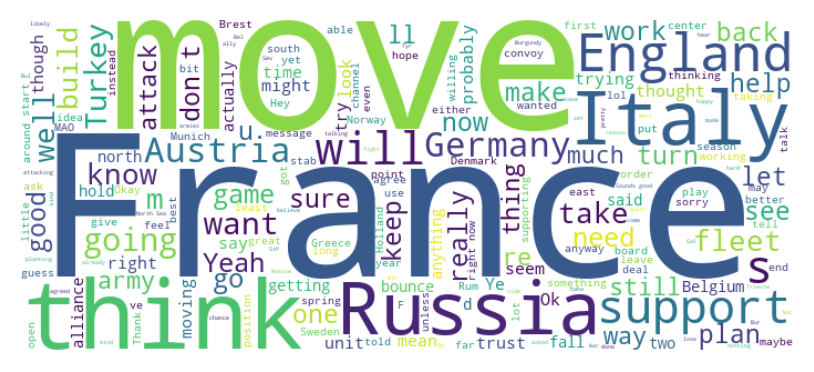

In [27]:
generate_wordcloud(df_explode, 'messages')

In [ ]:
# Se genera la nube de palabras para ver en todo el set de mensajes cuales son las palabras mas relevantes, encontrando
# como mas relevantes "move" y "France"

### Limpieza de mensajes

In [24]:
df_explode_cleaned = remove_nan_rows(df_explode)
df_val_cleaned = remove_nan_rows(df_val)
df_test_cleaned = remove_nan_rows(df_test)

df_explode_cleaned.head()

messages sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...          True   
1  You've whet my appetite, Italy. What's the sug...          True   
2                                                  👍          True   
3  It seems like there are a lot of ways that cou...          True   
4  Yeah, I can’t say I’ve tried it and it works, ...          True   

  receiver_labels speakers receivers absolute_message_index  \
0            True    italy   germany                     74   
1            True  germany     italy                     76   
2            True    italy   germany                     86   
3            True  germany     italy                     87   
4    NOANNOTATION    italy   germany                     89   

  relative_message_index seasons years game_score game_score_delta  \
0                      0  Spring  1901          3                0   
1                      1  Spring  1901          3                0   
2                      2  Spring  1901          3                0   
3                      3  Spring  1901          3                0   
4                      4  Spring  1901          3                0   

            players  game_id  caracteres_texto  coincide  
0  [italy, germany]        1             469.0      True  
1  [italy, germany]        1              54.0      True  
2  [italy, germany]        1               1.0      True  
3  [italy, germany]        1             186.0      True  
4  [italy, germany]        1             639.0     False

In [26]:

# Limpieza de datos
df_explode_cleaned['messages'] = df_explode_cleaned['messages'].astype(str)
df_explode_cleaned.loc[:, 'messages_clean'] = df_explode_cleaned['messages'].apply(lambda cw: remove_tags(cw, remove_special_chars=True, remove_stopwords=True, remove_newlines=True))

df_val_cleaned['messages'] = df_val_cleaned['messages'].astype(str)
df_val_cleaned.loc[:, 'messages_clean'] = df_val_cleaned['messages'].apply(lambda cw: remove_tags(cw, remove_special_chars=True, remove_stopwords=True, remove_newlines=True))

df_test_cleaned['messages'] = df_test_cleaned['messages'].astype(str)
df_test_cleaned.loc[:, 'messages_clean'] = df_test_cleaned['messages'].apply(lambda cw: remove_tags(cw, remove_special_chars=True, remove_stopwords=True, remove_newlines=True))


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_28392\3547060594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode_cleaned['messages'] = df_explode_cleaned['messages'].astype(str)
C:\Users\Jelb7\AppData\Local\Temp\ipykernel_28392\3547060594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode_cleaned.loc[:, 'messages_clean'] = df_explode_cleaned['messages'].apply(lambda cw: remove_tags(cw, remove_special_chars=True, remove_stopwords=True, remove_newlines=True))
C:\Users\Jelb7\AppData\Loca

In [27]:
# Limpieza de nulos

df_explode_cleaned = remove_nan_rows(df_explode_cleaned)

df_val_cleaned = remove_nan_rows(df_val_cleaned)

df_test_cleaned = remove_nan_rows(df_test_cleaned)


df_explode_cleaned.head()



messages sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...          True   
1  You've whet my appetite, Italy. What's the sug...          True   
2                                                  👍          True   
3  It seems like there are a lot of ways that cou...          True   
4  Yeah, I can’t say I’ve tried it and it works, ...          True   

  receiver_labels speakers receivers absolute_message_index  \
0            True    italy   germany                     74   
1            True  germany     italy                     76   
2            True    italy   germany                     86   
3            True  germany     italy                     87   
4    NOANNOTATION    italy   germany                     89   

  relative_message_index seasons years game_score game_score_delta  \
0                      0  Spring  1901          3                0   
1                      1  Spring  1901          3                0   
2                      2  Spring  1901          3                0   
3                      3  Spring  1901          3                0   
4                      4  Spring  1901          3                0   

            players  game_id  caracteres_texto  coincide  \
0  [italy, germany]        1             469.0      True   
1  [italy, germany]        1              54.0      True   
2  [italy, germany]        1               1.0      True   
3  [italy, germany]        1             186.0      True   
4  [italy, germany]        1             639.0     False   

                                      messages_clean  
0  germany person want speak somewhat crazy idea ...  
1                     whet appetite italy suggestion  
2                                                     
3  seems like lot ways could go wrong see france ...  
4  yeah say tried works cause never tried seen th...

In [28]:
# Revisión de efecto de la limpieza del texto de los mensajes
prueba = df_explode_cleaned.sample()
print('Mensaje:', prueba.iloc[0]['messages'])
print('Mensaje limpio:', prueba.iloc[0]['messages_clean'])

Mensaje: But let’s talk abut how to fix this later!
Mensaje limpio: let talk abut fix later


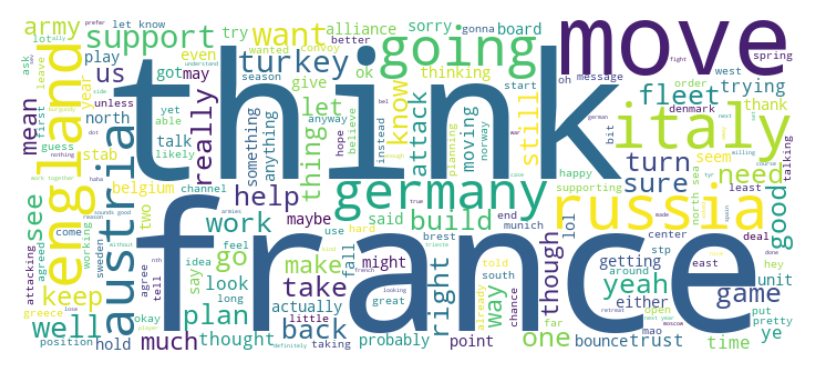

In [32]:
generate_wordcloud(df_explode_cleaned, 'messages_clean')

In [ ]:
# COn las palabras limpias, toma mas relavancia las palabras Think y France

### Analisis de datos despues de limpieza

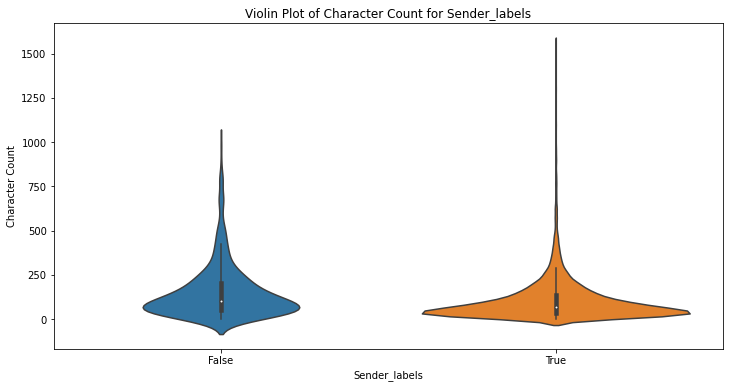

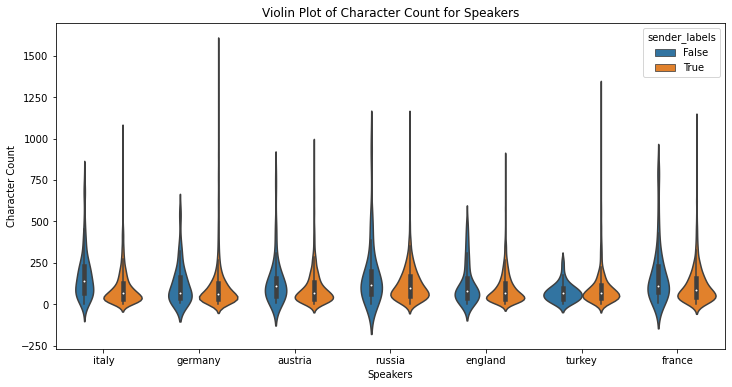

In [29]:
plot_character_count(df_explode_cleaned, x_col='sender_labels', y_col='caracteres_texto')
plot_character_count(df_explode_cleaned, x_col='speakers', y_col='caracteres_texto', hue_col='sender_labels')


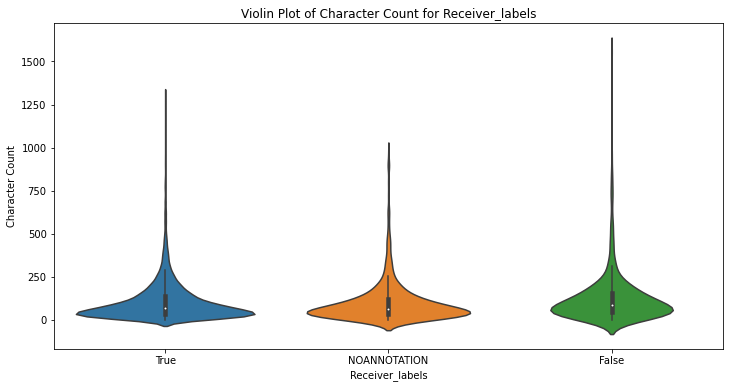

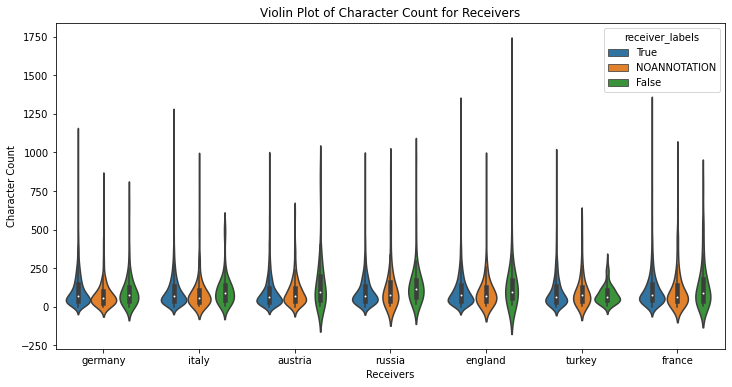

In [34]:
plot_character_count(df_explode_cleaned, x_col='receiver_labels', y_col='caracteres_texto')
plot_character_count(df_explode_cleaned, x_col='receivers', y_col='caracteres_texto', hue_col='receiver_labels')



Proporción de publicaciones con info True: 0.8726012793176973
Proporción de publicaciones con info False: 0.043100822418519646


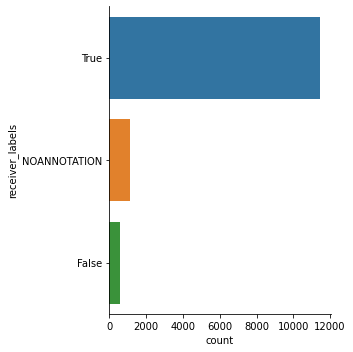

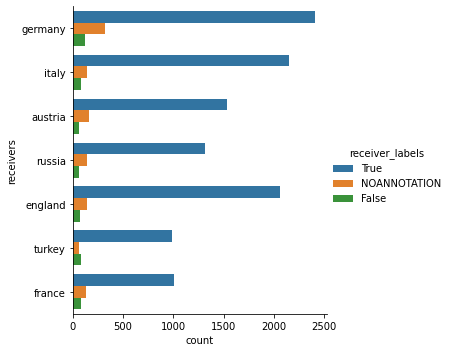

In [30]:
analyze_and_plot_sentiment(df_explode_cleaned, 'messages_clean','receiver_labels',"receivers")

Proporción de publicaciones con info True: 0.9549954310082241
Proporción de publicaciones con info False: 0.045004568991775816


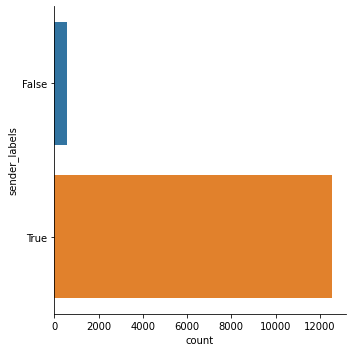

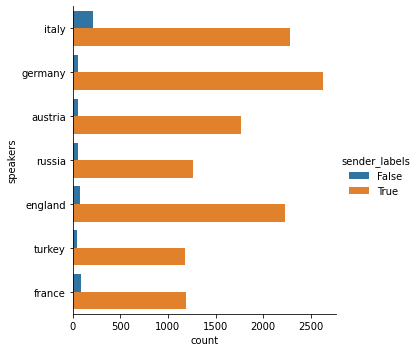

In [31]:
analyze_and_plot_sentiment(df_explode_cleaned, 'messages_clean','sender_labels','speakers')

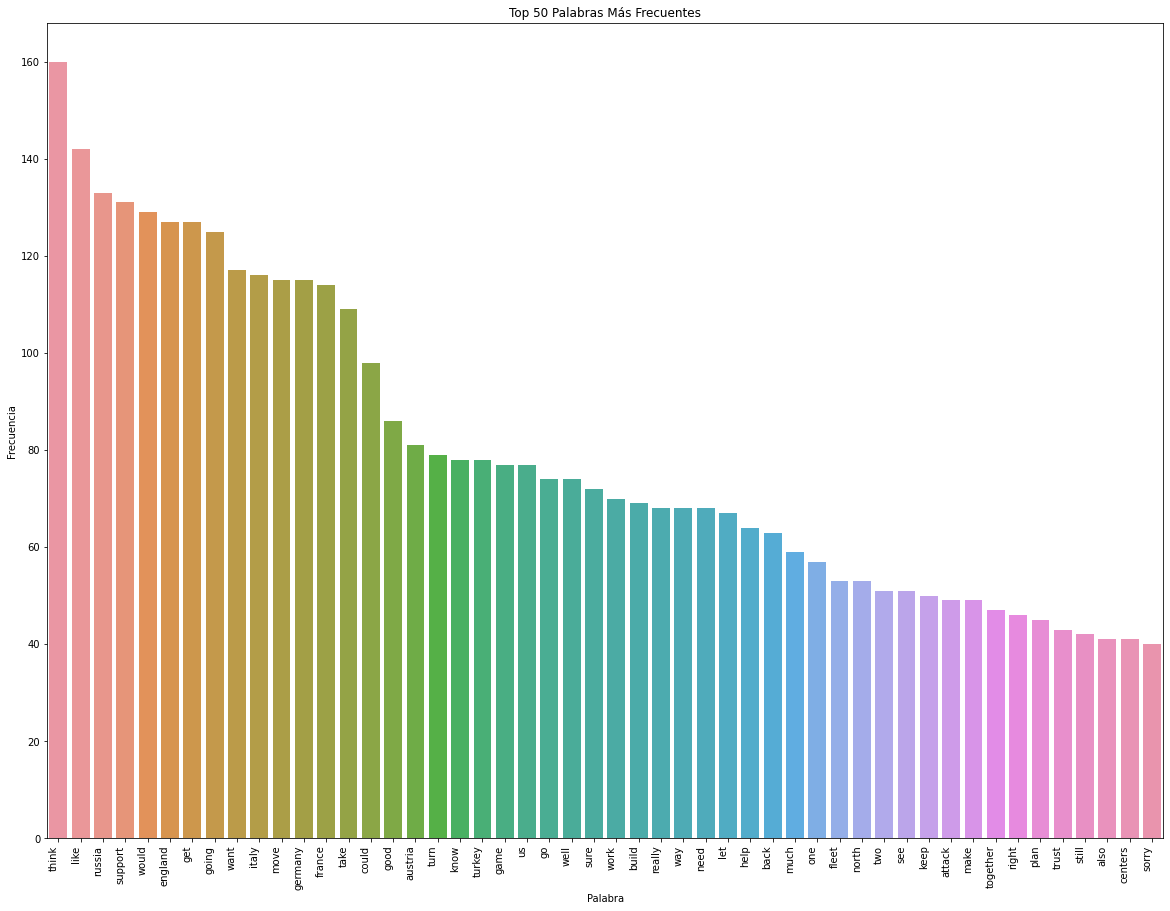

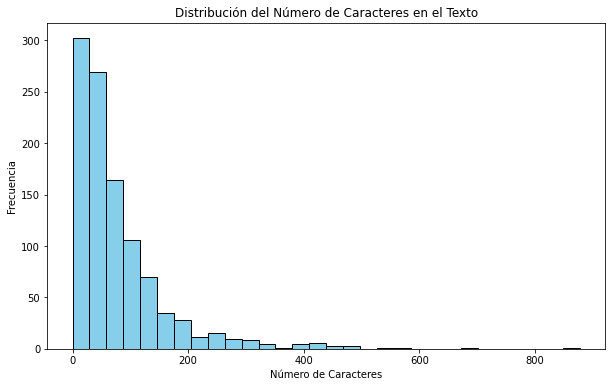

Promedio del número de caracteres en el texto: 78.95


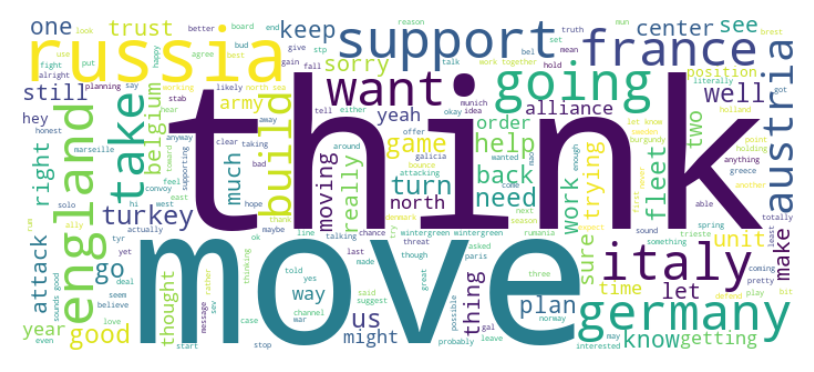

Proporción de publicaciones con info True: 0.4789674952198853
Proporción de publicaciones con info False: 0.5210325047801148


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



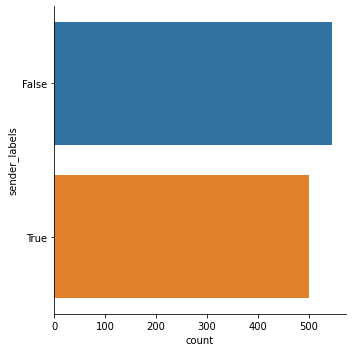

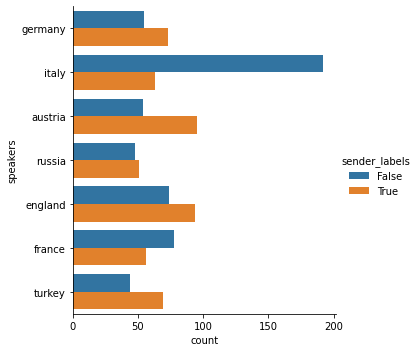

Proporción de publicaciones con info True: 0.4588910133843212
Proporción de publicaciones con info False: 0.5411089866156787


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



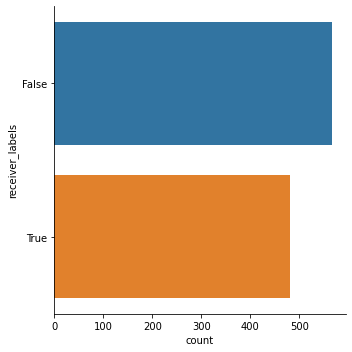

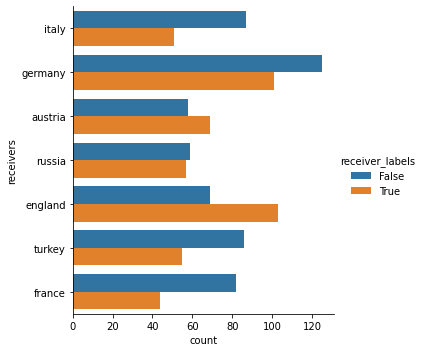

In [37]:
# se filtra de tal manera que se tiene todos los casos y posiciones en que hay false 
filtered_ft = df_explode_cleaned[(df_explode_cleaned['sender_labels'] == False) & (df_explode_cleaned['receiver_labels'] == True) | 
                 (df_explode_cleaned['sender_labels'] == True) & (df_explode_cleaned['receiver_labels'] == False)| 
                 (df_explode_cleaned['sender_labels'] == False) & (df_explode_cleaned['receiver_labels'] == False)]
plot_top_words_frequency(filtered_ft, 'messages_clean')
plot_and_average_text_length(filtered_ft)

generate_wordcloud(filtered_ft, 'messages_clean')
analyze_and_plot_sentiment(filtered_ft, 'messages_clean','sender_labels','speakers')
analyze_and_plot_sentiment(filtered_ft, 'messages_clean','receiver_labels',"receivers")

In [ ]:
# Se nota que mayormente las mentiras o los mensajes que generan desconfianza tienen 50 caracteres aproximadamente
# se confirma adicionalmente las conclusiones de las graficas anteriores, es importante crear un filtro para poder balancear
# las clases

In [38]:
filtered_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 8 to 13133
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                1046 non-null   object
 1   sender_labels           1046 non-null   object
 2   receiver_labels         1046 non-null   object
 3   speakers                1046 non-null   object
 4   receivers               1046 non-null   object
 5   absolute_message_index  1046 non-null   object
 6   relative_message_index  1046 non-null   object
 7   seasons                 1046 non-null   object
 8   years                   1046 non-null   object
 9   game_score              1046 non-null   object
 10  game_score_delta        1046 non-null   object
 11  players                 1046 non-null   object
 12  game_id                 1046 non-null   int64 
 13  caracteres_texto        1046 non-null   int64 
 14  coincide                1046 non-null   bool  
 15  mes

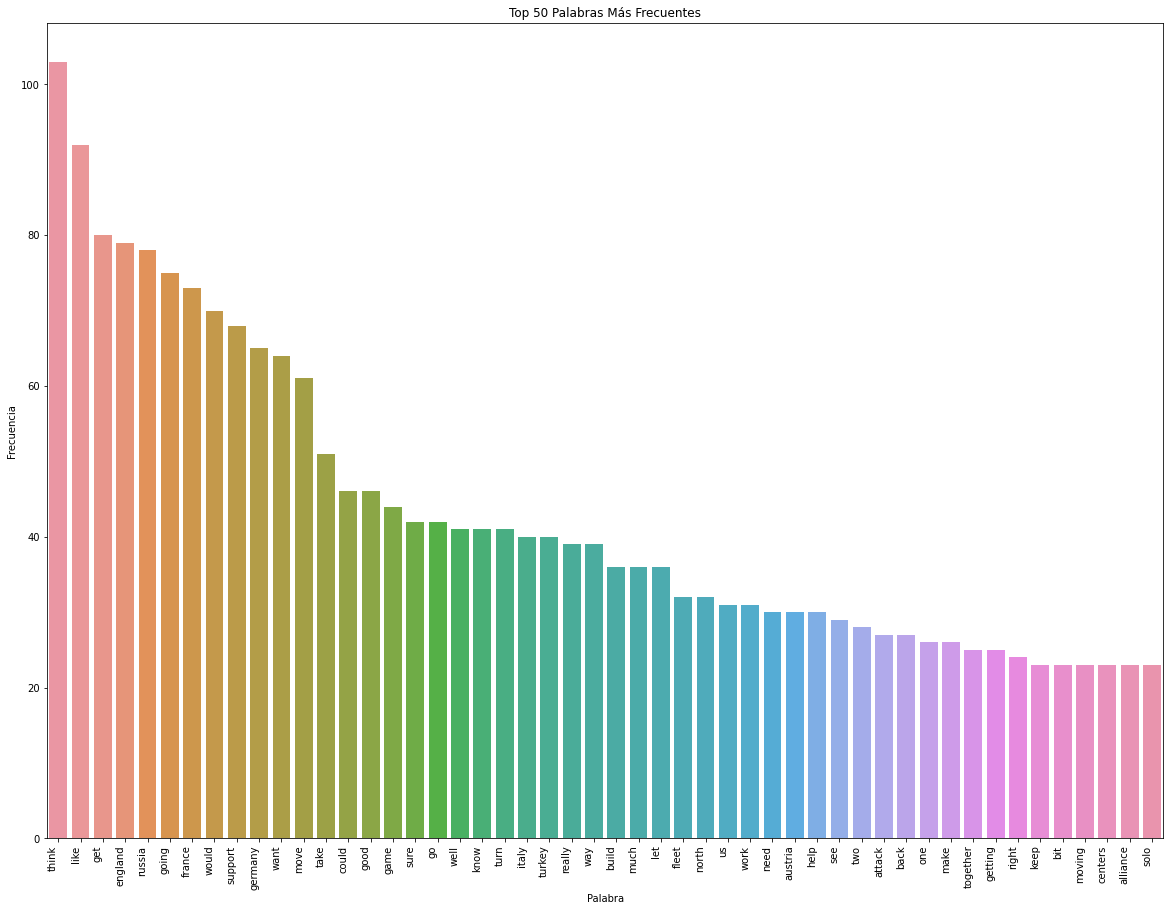

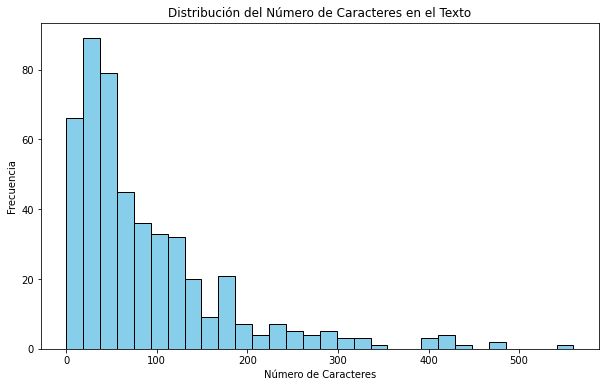

Promedio del número de caracteres en el texto: 88.25


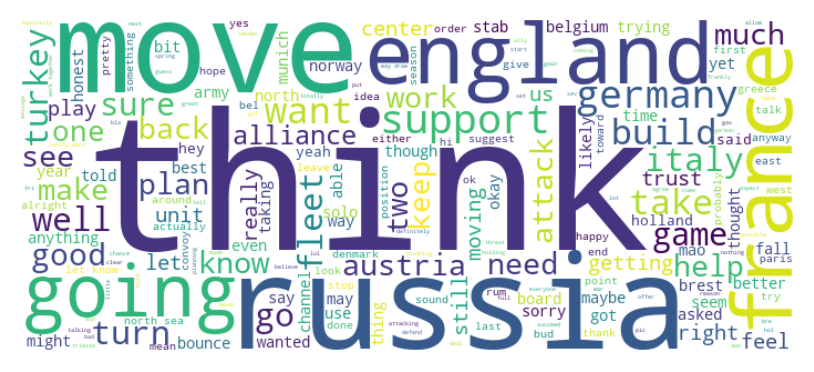

Proporción de publicaciones con info False: 1.0


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



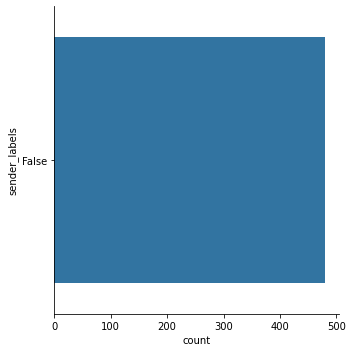

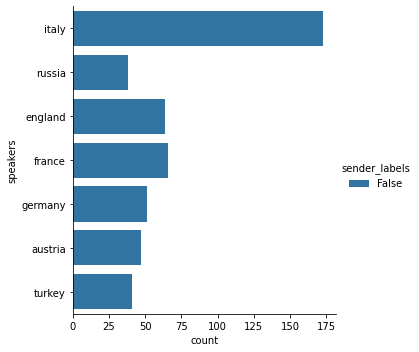

Proporción de publicaciones con info False: 0.0


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



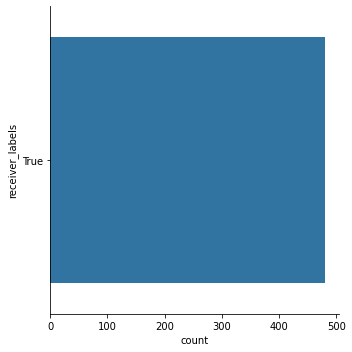

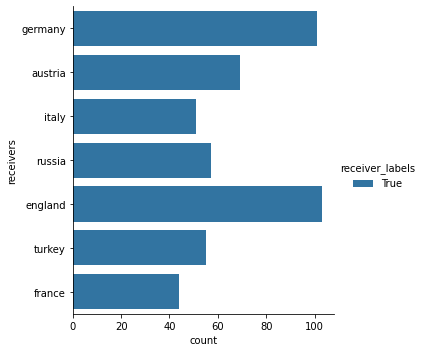

In [39]:
# Filtro, cuando se dicen mentiras
filtered_df = df_explode_cleaned[(df_explode_cleaned['sender_labels'] == False) & (df_explode_cleaned['receiver_labels'] == True)]
plot_top_words_frequency(filtered_df, 'messages_clean')
plot_and_average_text_length(filtered_df)
generate_wordcloud(filtered_df, 'messages_clean')
analyze_and_plot_sentiment(filtered_df, 'messages_clean','sender_labels','speakers')
analyze_and_plot_sentiment(filtered_df, 'messages_clean','receiver_labels',"receivers")

In [ ]:
# En este caso se evidencia que las mentiras son normalemnte mayoritaria en mensajes de entre 40 y 60 caraacteres de
# texto, adicionalmente palabras como think, russia, move, y england resaltan por su frecuencia, pais con mas mentiras
# italy

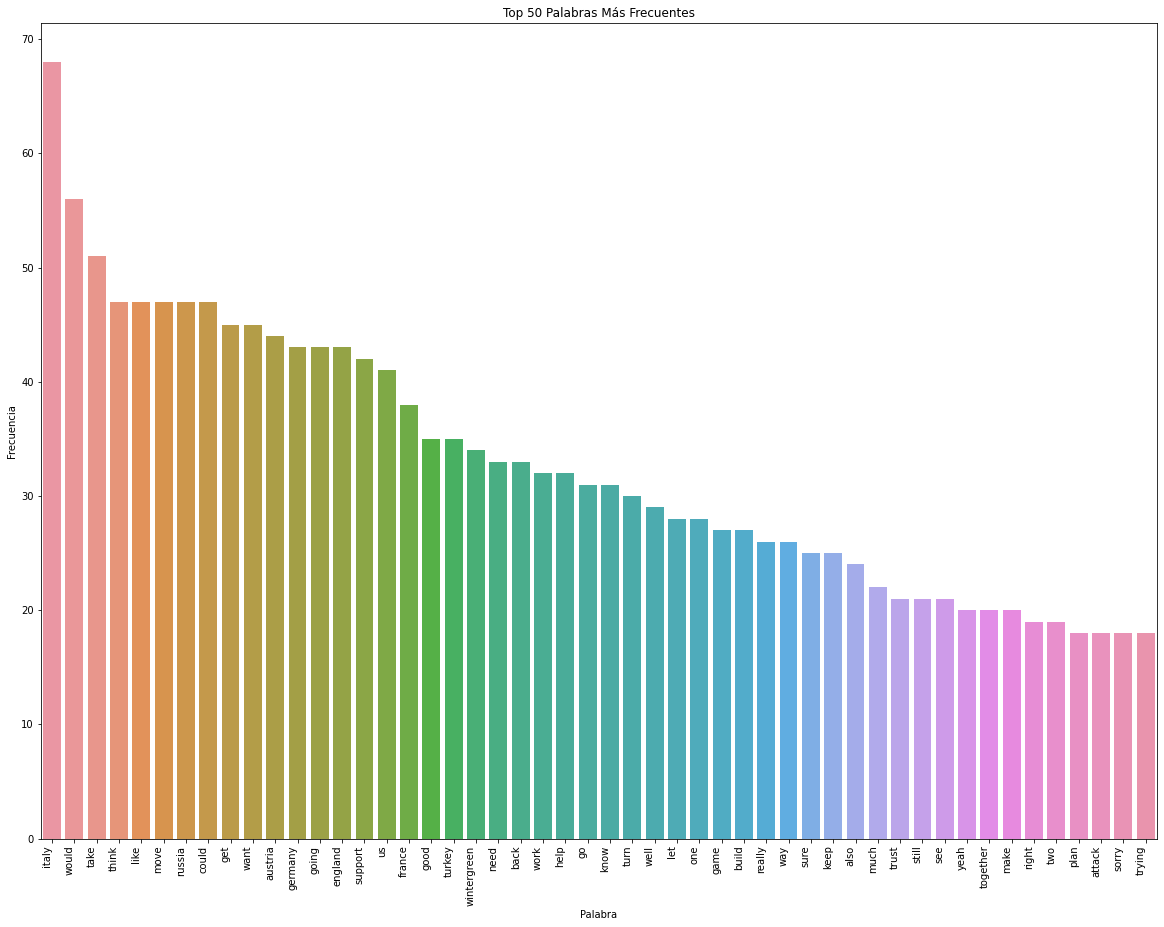

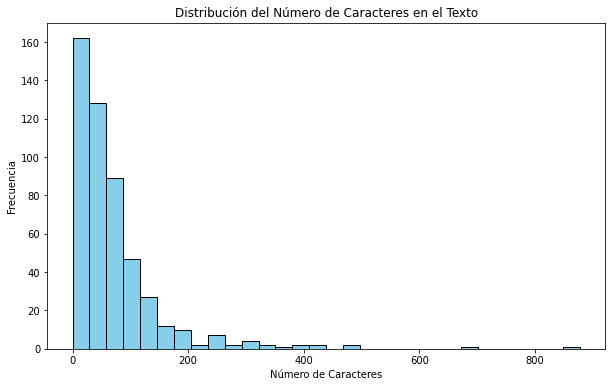

Promedio del número de caracteres en el texto: 71.13


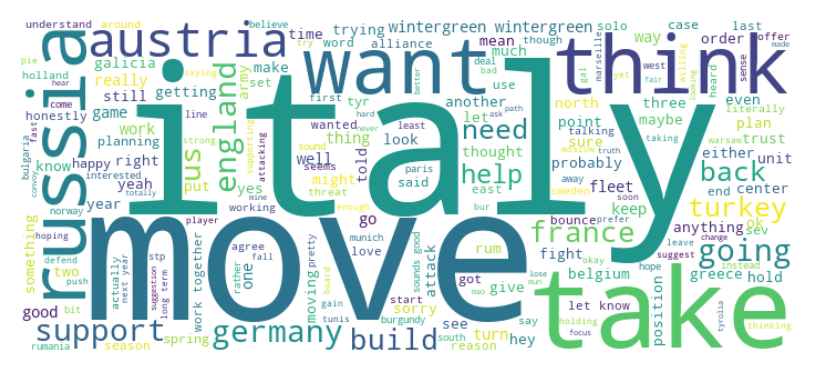

Proporción de publicaciones con info True: 1.0


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



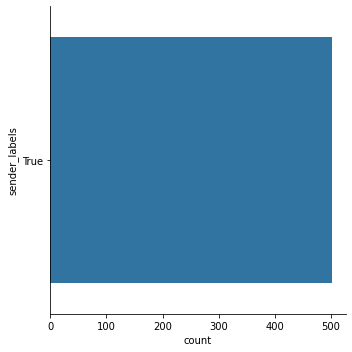

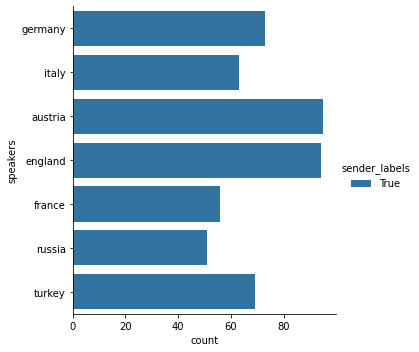

Proporción de publicaciones con info True: 0.0


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



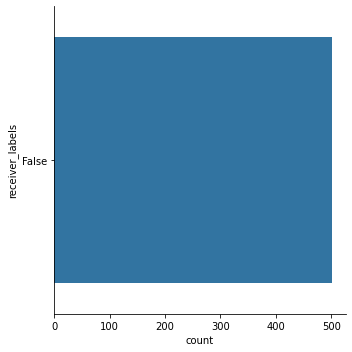

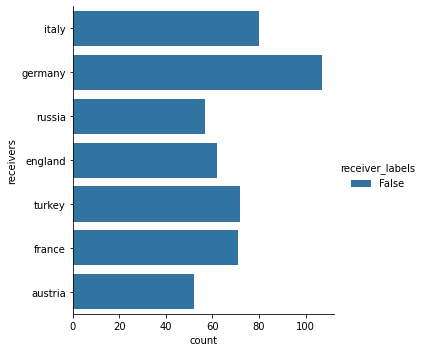

In [40]:
#Filtro de desconfianza
filtered_df = df_explode_cleaned[(df_explode_cleaned['sender_labels'] == True) & (df_explode_cleaned['receiver_labels'] == False)]
plot_top_words_frequency(filtered_df, 'messages_clean')
plot_and_average_text_length(filtered_df)
generate_wordcloud(filtered_df, 'messages_clean')
analyze_and_plot_sentiment(filtered_df, 'messages_clean','sender_labels','speakers')
analyze_and_plot_sentiment(filtered_df, 'messages_clean','receiver_labels',"receivers")

In [ ]:
# resalta que las palabras con menor co igual cantidad de 25 caracteres aprox, son verdaderas sin embargo,
# el receptor las toma como falsas, y le es dificil clasificarlas como mentiras

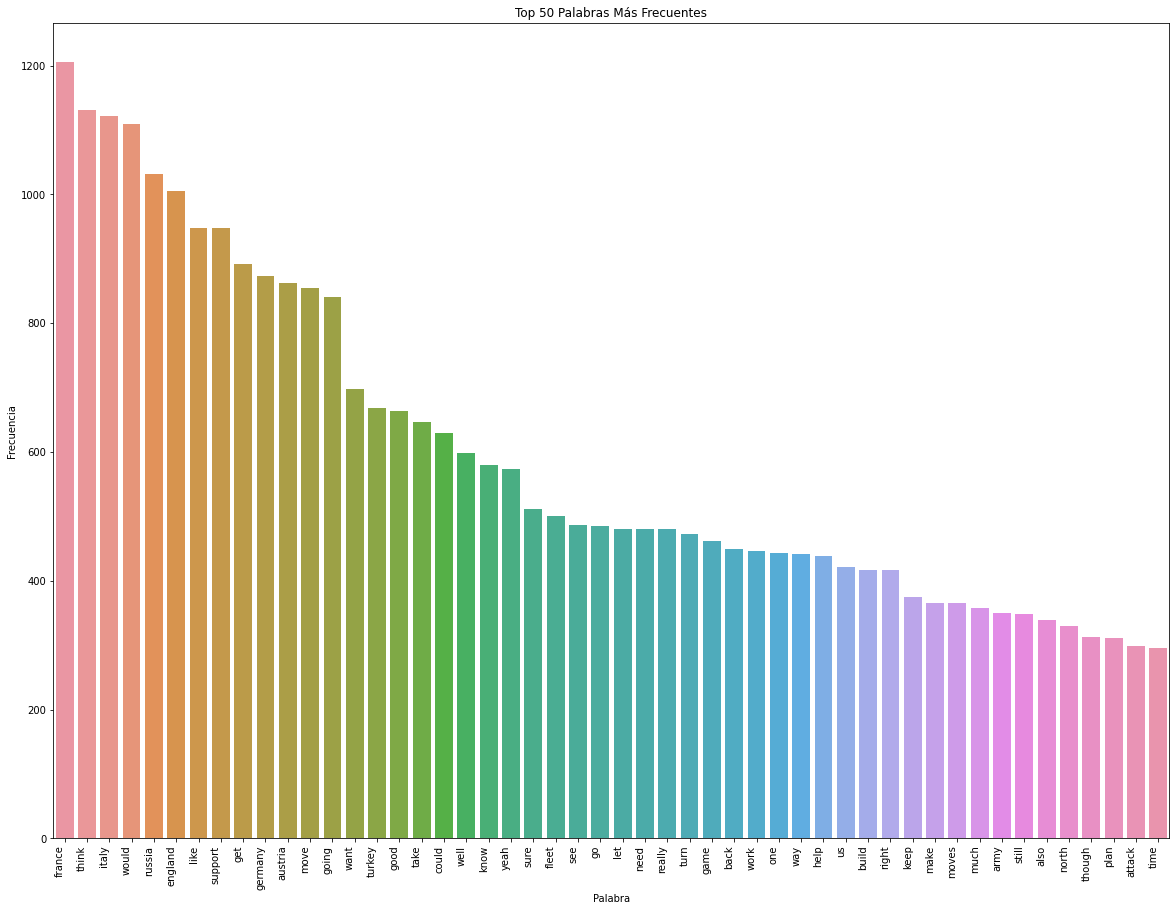

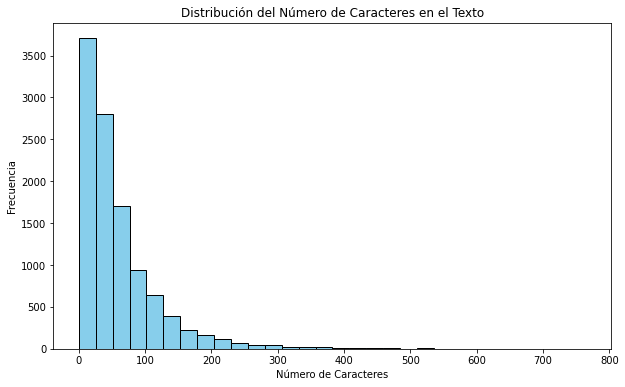

Promedio del número de caracteres en el texto: 59.73


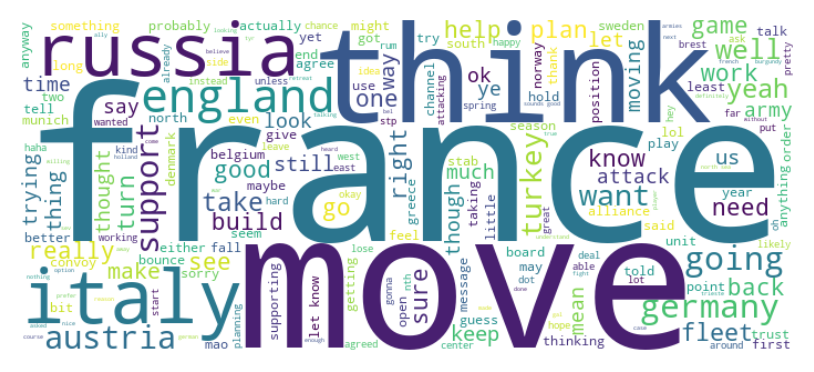

Proporción de publicaciones con info True: 1.0


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



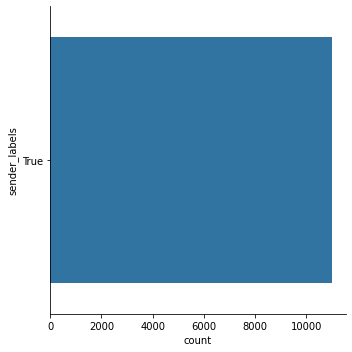

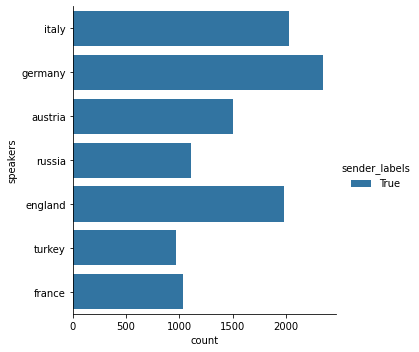

Proporción de publicaciones con info True: 1.0


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



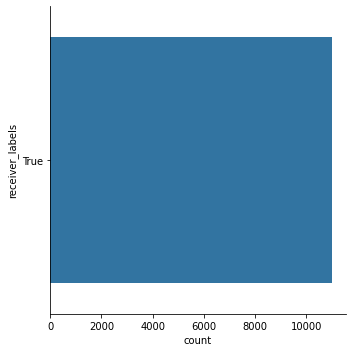

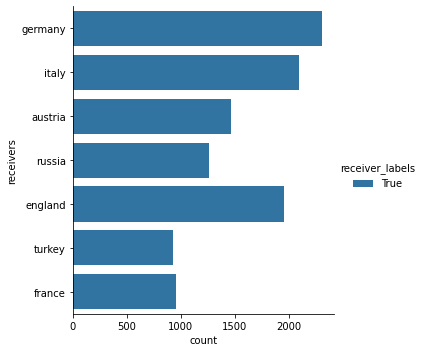

In [41]:
# Filtro de la verdad
filtered_tt = df_explode_cleaned[(df_explode_cleaned['sender_labels'] == True) & (df_explode_cleaned['receiver_labels'] == True)]

plot_top_words_frequency(filtered_tt, 'messages_clean')
plot_and_average_text_length(filtered_tt)
generate_wordcloud(filtered_tt, 'messages_clean')
analyze_and_plot_sentiment(filtered_tt, 'messages_clean','sender_labels','speakers')
analyze_and_plot_sentiment(filtered_tt, 'messages_clean','receiver_labels',"receivers")

In [ ]:
# Resalta que las verdades eestan en una gran proporcion concentradas en mensajes de 20 caracteres o menos, adicionalmente,
# se evidencia que las palabras mas frecuentes son similares a las mentiras, por lo que no es una buena alternativa 
# identificar mentiras de acuerdo solo a sus palabras mas frecuentes

In [42]:
filtered_tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10979 entries, 0 to 13135
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                10979 non-null  object
 1   sender_labels           10979 non-null  object
 2   receiver_labels         10979 non-null  object
 3   speakers                10979 non-null  object
 4   receivers               10979 non-null  object
 5   absolute_message_index  10979 non-null  object
 6   relative_message_index  10979 non-null  object
 7   seasons                 10979 non-null  object
 8   years                   10979 non-null  object
 9   game_score              10979 non-null  object
 10  game_score_delta        10979 non-null  object
 11  players                 10979 non-null  object
 12  game_id                 10979 non-null  int64 
 13  caracteres_texto        10979 non-null  int64 
 14  coincide                10979 non-null  bool  
 15  me

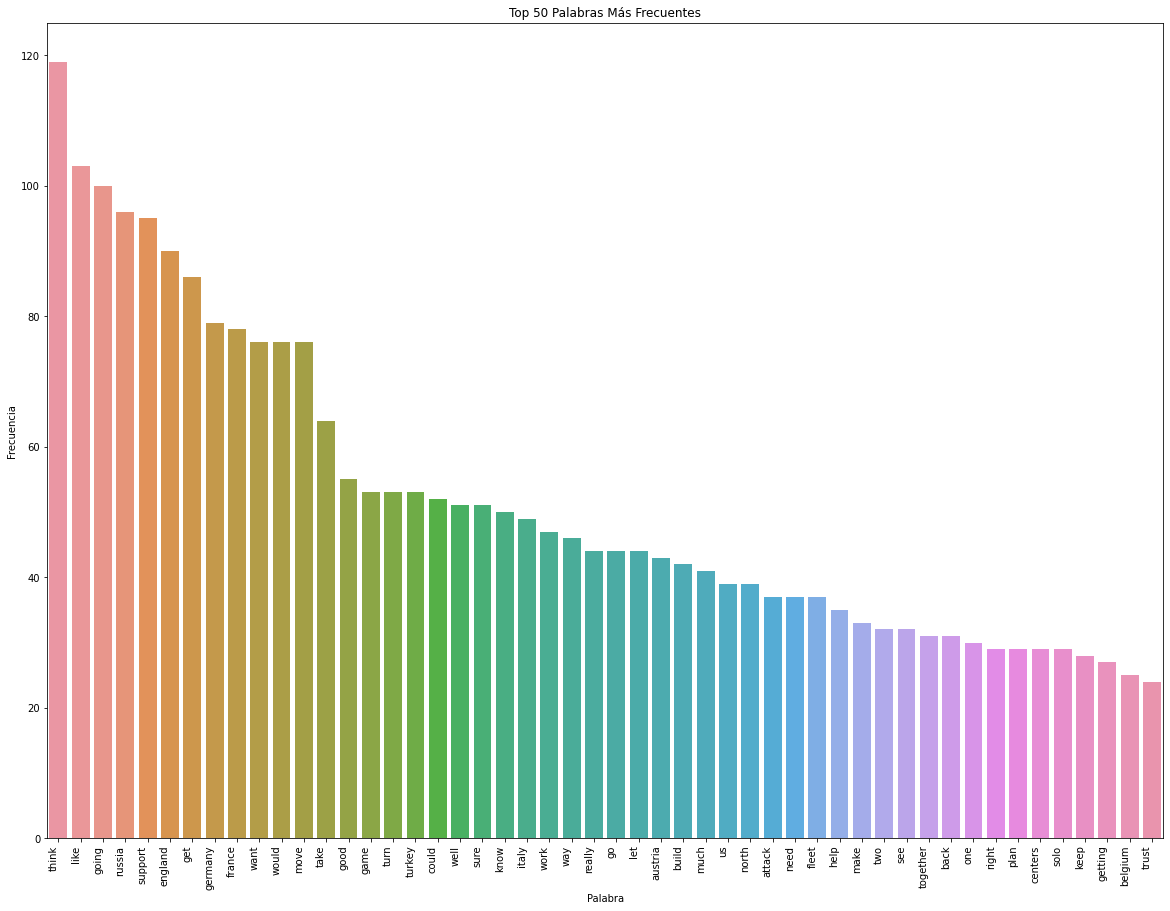

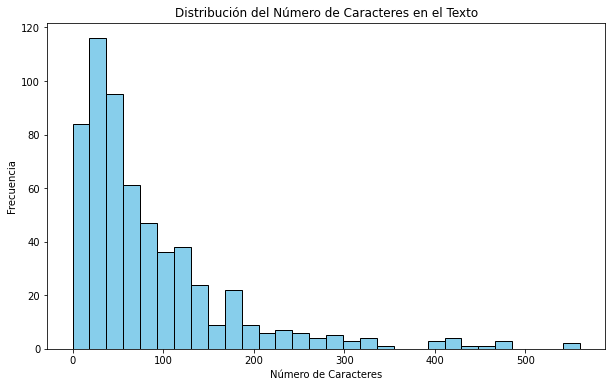

Promedio del número de caracteres en el texto: 85.88


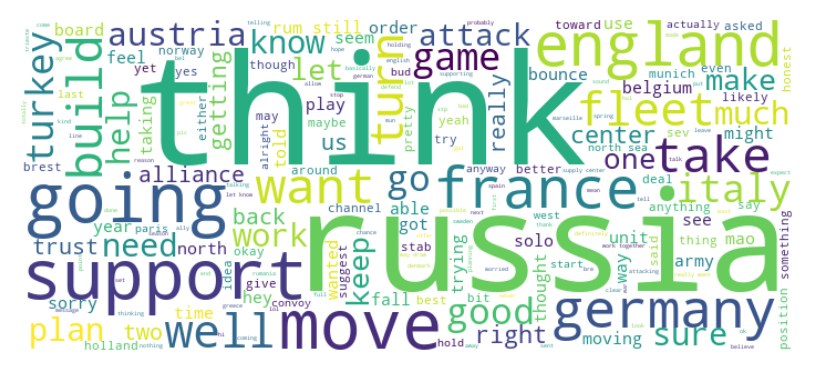

Proporción de publicaciones con info False: 1.0


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



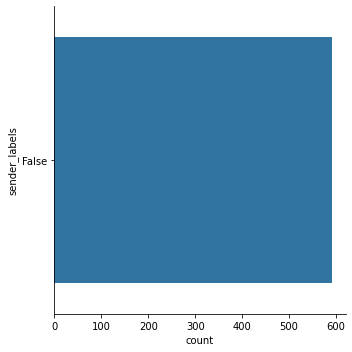

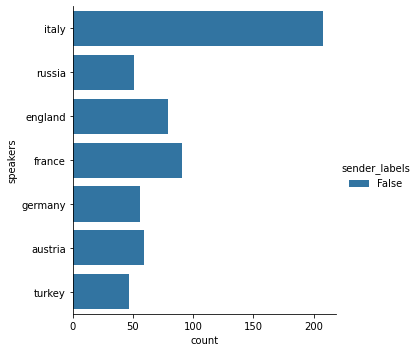

Proporción de publicaciones con info False: 0.10998307952622674


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



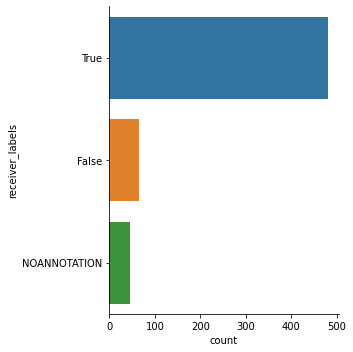

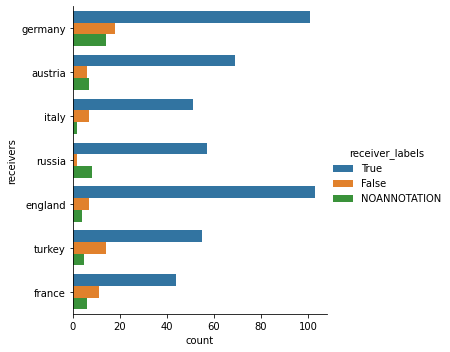

In [43]:
# Filtro, cuando se dicen mentiras
filtered_f = df_explode_cleaned[(df_explode_cleaned['sender_labels'] == False)]
plot_top_words_frequency(filtered_f, 'messages_clean')
plot_and_average_text_length(filtered_f)
generate_wordcloud(filtered_f, 'messages_clean')
analyze_and_plot_sentiment(filtered_f, 'messages_clean','sender_labels','speakers')
analyze_and_plot_sentiment(filtered_f, 'messages_clean','receiver_labels',"receivers")


In [ ]:
# Conclusiones similares a cuando se reciben las mentiras

In [44]:
filtered_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 132 to 13120
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                591 non-null    object
 1   sender_labels           591 non-null    object
 2   receiver_labels         591 non-null    object
 3   speakers                591 non-null    object
 4   receivers               591 non-null    object
 5   absolute_message_index  591 non-null    object
 6   relative_message_index  591 non-null    object
 7   seasons                 591 non-null    object
 8   years                   591 non-null    object
 9   game_score              591 non-null    object
 10  game_score_delta        591 non-null    object
 11  players                 591 non-null    object
 12  game_id                 591 non-null    int64 
 13  caracteres_texto        591 non-null    int64 
 14  coincide                591 non-null    bool  
 15  me

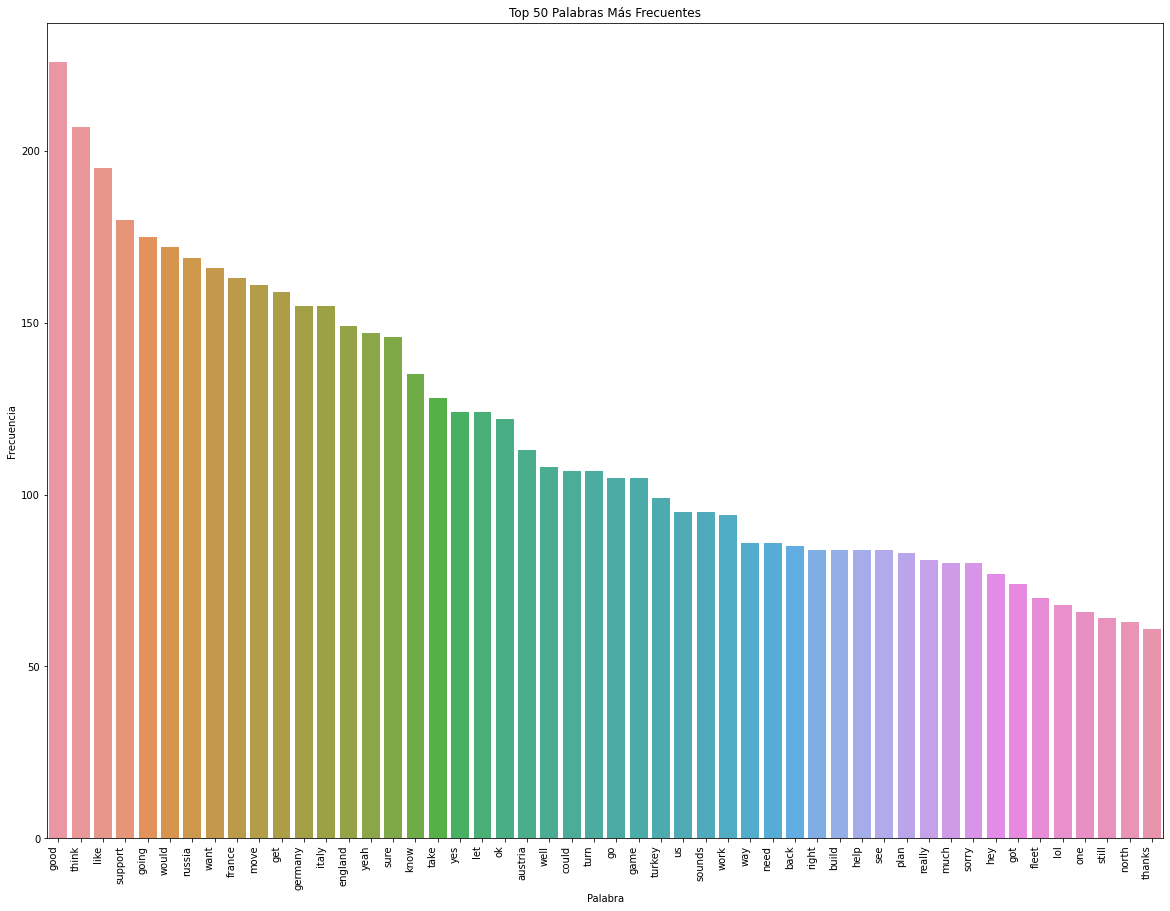

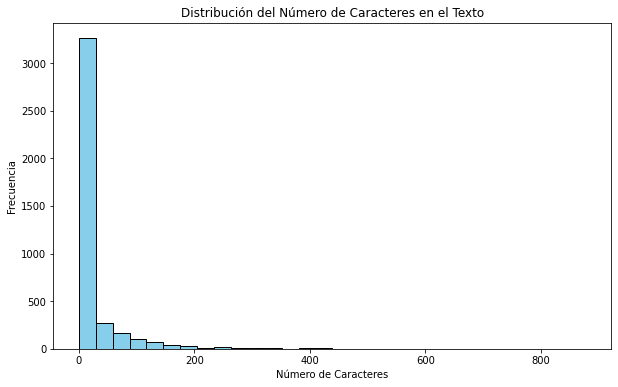

Promedio del número de caracteres en el texto: 28.77


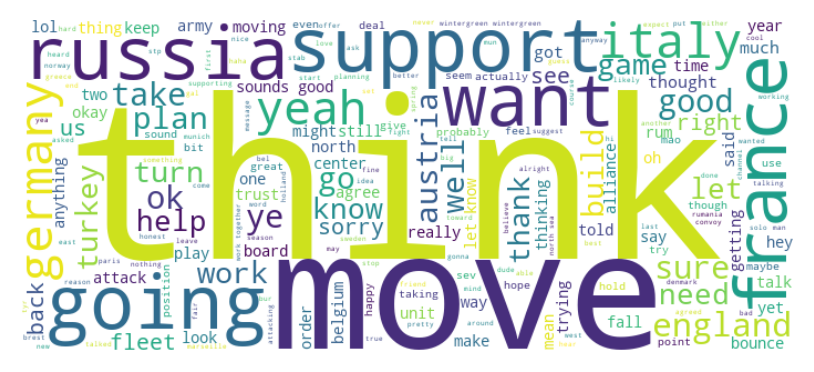

Proporción de publicaciones con info True: 0.8638861138861139
Proporción de publicaciones con info False: 0.1361138861138861


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



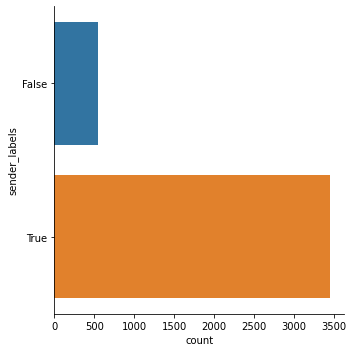

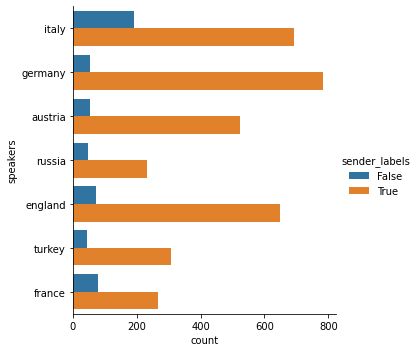

Proporción de publicaciones con info True: 0.8586413586413586
Proporción de publicaciones con info False: 0.14135864135864135


C:\Users\Jelb7\AppData\Local\Temp\ipykernel_4100\131322867.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



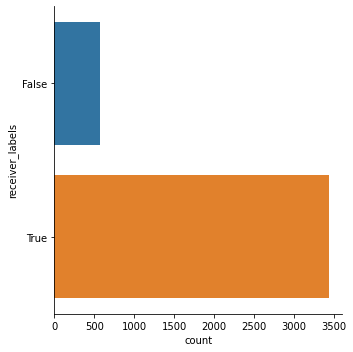

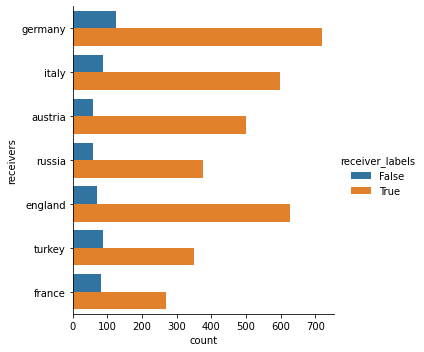

In [45]:
# Dado a la exploracion anterior, y debido a las dificultades que puede traer el balanceo de clases con estrategias como SMOTE,
# ademas de que es muy costoso computacionalmente y se esta desarrollando en un pc personal este ejercicio, se decide 
# explorar de acuerdo a las conclusiones anteriores, implementar un filtro de tal manera que con reglas duras se pueda
# mejorar la proporcion de las clases sin necesidad de agregar informacion, teniendo en cuenta que, el ejercicio en cuestion
# de que se quiere entrenar un modelo de tal manera que detecte mentiras, se van a tomar todos los casos de mentiras asi como
# los casos de desconfianza, adicionalmente para filtrar los casos verdaderos se toma un filtro de que la cantidad de caracteres
# sea igual o menor a 20 ya que es la cantidad de caracteres que concentran al rededor de 4000 mensajes, por lo que se
# considera un buen input para entrenar un modelo
filtered_dfb = df_explode_cleaned[(df_explode_cleaned['sender_labels'] == False) & (df_explode_cleaned['receiver_labels'] == True) | 
                 (df_explode_cleaned['sender_labels'] == True) & (df_explode_cleaned['receiver_labels'] == False)| 
                 (df_explode_cleaned['sender_labels'] == False) & (df_explode_cleaned['receiver_labels'] == False)| 
                 (df_explode_cleaned['sender_labels'] == True) & (df_explode_cleaned['receiver_labels'] == True) & (df_explode_cleaned['caracteres_texto'] <= 20)]

plot_top_words_frequency(filtered_dfb, 'messages_clean')
plot_and_average_text_length(filtered_dfb)
generate_wordcloud(filtered_dfb, 'messages_clean')
analyze_and_plot_sentiment(filtered_dfb, 'messages_clean','sender_labels','speakers')
analyze_and_plot_sentiment(filtered_dfb, 'messages_clean','receiver_labels',"receivers")

In [ ]:
# Se nora que la proporcion de clases es ahora de 85% True, y 15% false

In [46]:
filtered_dfb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4004 entries, 2 to 13135
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                4004 non-null   object
 1   sender_labels           4004 non-null   object
 2   receiver_labels         4004 non-null   object
 3   speakers                4004 non-null   object
 4   receivers               4004 non-null   object
 5   absolute_message_index  4004 non-null   object
 6   relative_message_index  4004 non-null   object
 7   seasons                 4004 non-null   object
 8   years                   4004 non-null   object
 9   game_score              4004 non-null   object
 10  game_score_delta        4004 non-null   object
 11  players                 4004 non-null   object
 12  game_id                 4004 non-null   int64 
 13  caracteres_texto        4004 non-null   int64 
 14  coincide                4004 non-null   bool  
 15  mes

### Acercamiento con NER

In [49]:
text = df_explode_cleaned.messages_clean[0]
doc = nlp(text)

for token in doc:

    print(token.pos_, token.dep_)
            

PROPN compound
PROPN nsubj
VERB ROOT
VERB xcomp
ADV advmod
ADJ amod
NOUN dobj
ADV advmod
VERB advcl
AUX aux
ADV neg
ADV advmod
VERB ccomp
NOUN nsubj
VERB ccomp
ADJ advmod
AUX aux
VERB ccomp
ADJ amod
NOUN nsubj
VERB ccomp
ADJ amod
NOUN compound
NOUN compound
NOUN compound
PRON nsubj
ADJ amod
ADJ amod
NOUN appos
VERB acl
AUX aux
VERB ccomp
NOUN compound
NOUN dobj
INTJ advmod
VERB npadvmod
ADP prep
ADJ amod
ADJ pobj


In [50]:
df_explode_cleaned = create_tfidf_column(df_explode_cleaned, 'messages_clean', max_keywords=5)
df_tfidf=create_tfidf_column(df_explode_cleaned, 'messages_clean', max_keywords=5)

In [51]:
df_tfidf.head()

messages sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...          True   
1  You've whet my appetite, Italy. What's the sug...          True   
2                                                  👍          True   
3  It seems like there are a lot of ways that cou...          True   
4  Yeah, I can’t say I’ve tried it and it works, ...          True   

  receiver_labels speakers receivers absolute_message_index  \
0            True    italy   germany                     74   
1            True  germany     italy                     76   
2            True    italy   germany                     86   
3            True  germany     italy                     87   
4    NOANNOTATION    italy   germany                     89   

  relative_message_index seasons years game_score game_score_delta  \
0                      0  Spring  1901          3                0   
1                      1  Spring  1901          3                0   
2                      2  Spring  1901          3                0   
3                      3  Spring  1901          3                0   
4                      4  Spring  1901          3                0   

            players  game_id  caracteres_texto  coincide  \
0  [italy, germany]        1               261      True   
1  [italy, germany]        1                30      True   
2  [italy, germany]        1                 0      True   
3  [italy, germany]        1               115      True   
4  [italy, germany]        1               327     False   

                                      messages_clean  \
0  germany person want speak somewhat crazy idea ...   
1                     whet appetite italy suggestion   
2                                                      
3  seems like lot ways could go wrong see france ...   
4  yeah say tried works cause never tried seen th...   

                                               tfidf  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             summary  
0  sensing like idea shall talk something else cr...  
1  italy, italy done, suggestion specific game le...  
2  say, asked thought said nervous getting big ma...  
3  could found name three different ways, feel li...  
4  tried, looks like france sincere, looks like a...

In [ ]:
# Se genera una columna con las palabras con mayor similaridad por cada mensaje con la idea de dtectar patrones

In [52]:
df_tfidf=create_tfidf_column(df_explode_cleaned, 'messages_clean', max_keywords=5)
df_tfidf.head()

messages sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...          True   
1  You've whet my appetite, Italy. What's the sug...          True   
2                                                  👍          True   
3  It seems like there are a lot of ways that cou...          True   
4  Yeah, I can’t say I’ve tried it and it works, ...          True   

  receiver_labels speakers receivers absolute_message_index  \
0            True    italy   germany                     74   
1            True  germany     italy                     76   
2            True    italy   germany                     86   
3            True  germany     italy                     87   
4    NOANNOTATION    italy   germany                     89   

  relative_message_index seasons years game_score game_score_delta  \
0                      0  Spring  1901          3                0   
1                      1  Spring  1901          3                0   
2                      2  Spring  1901          3                0   
3                      3  Spring  1901          3                0   
4                      4  Spring  1901          3                0   

            players  game_id  caracteres_texto  coincide  \
0  [italy, germany]        1               261      True   
1  [italy, germany]        1                30      True   
2  [italy, germany]        1                 0      True   
3  [italy, germany]        1               115      True   
4  [italy, germany]        1               327     False   

                                      messages_clean  \
0  germany person want speak somewhat crazy idea ...   
1                     whet appetite italy suggestion   
2                                                      
3  seems like lot ways could go wrong see france ...   
4  yeah say tried works cause never tried seen th...   

                                               tfidf  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             summary  \
0  sensing like idea shall talk something else cr...   
1  italy, italy done, suggestion specific game le...   
2  say, asked thought said nervous getting big ma...   
3  could found name three different ways, feel li...   
4  tried, looks like france sincere, looks like a...   

                                summary_more_similar  \
0  sensing like idea shall talk something else cr...   
1  italy, italy done, suggestion specific game le...   
2  say, asked thought said nervous getting big ma...   
3  could found name three different ways, feel li...   
4  tried, looks like france sincere, looks like a...   

                                summary_less_similar  
0  done taking rumania spring, haha worries wake,...  
1  done taking rumania spring, wanting retreat bu...  
2  germany person want speak somewhat crazy idea ...  
3  deals, consideration problem remaining tys, su...  
4  deals, updated orders supporting moscow, kiddi...

In [ ]:
# Se genera dos columna que resumenes con las palabras con mayor y menor similaridad por mensaje

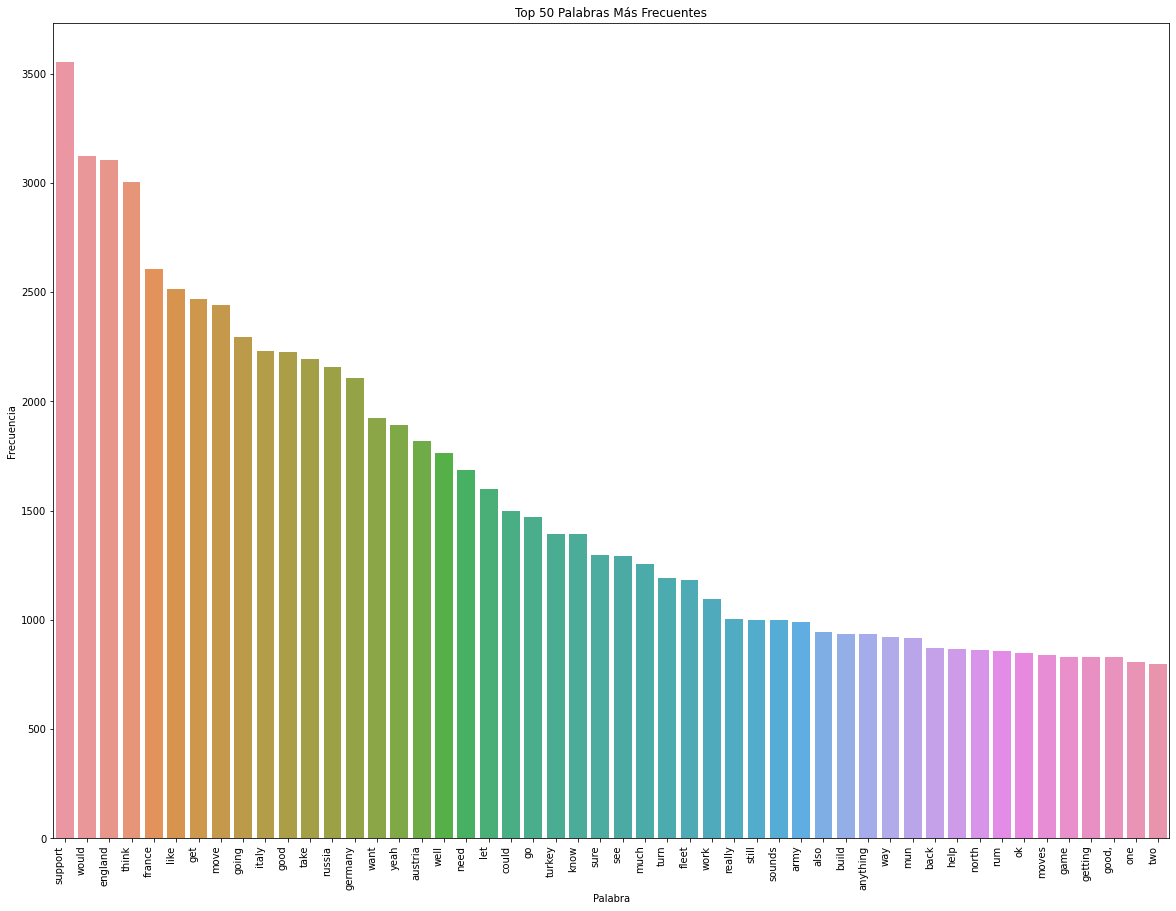

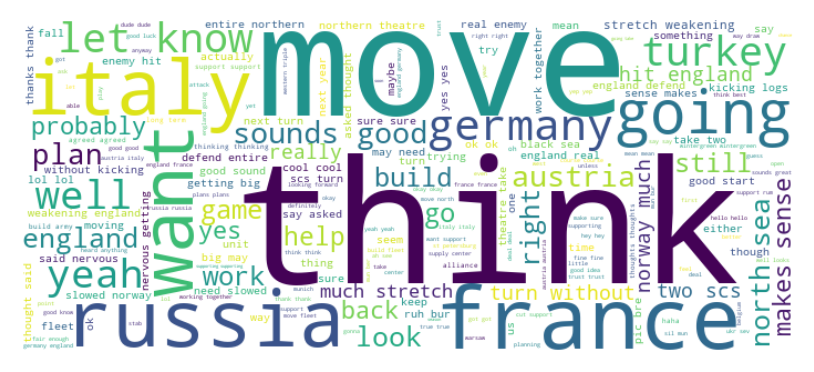

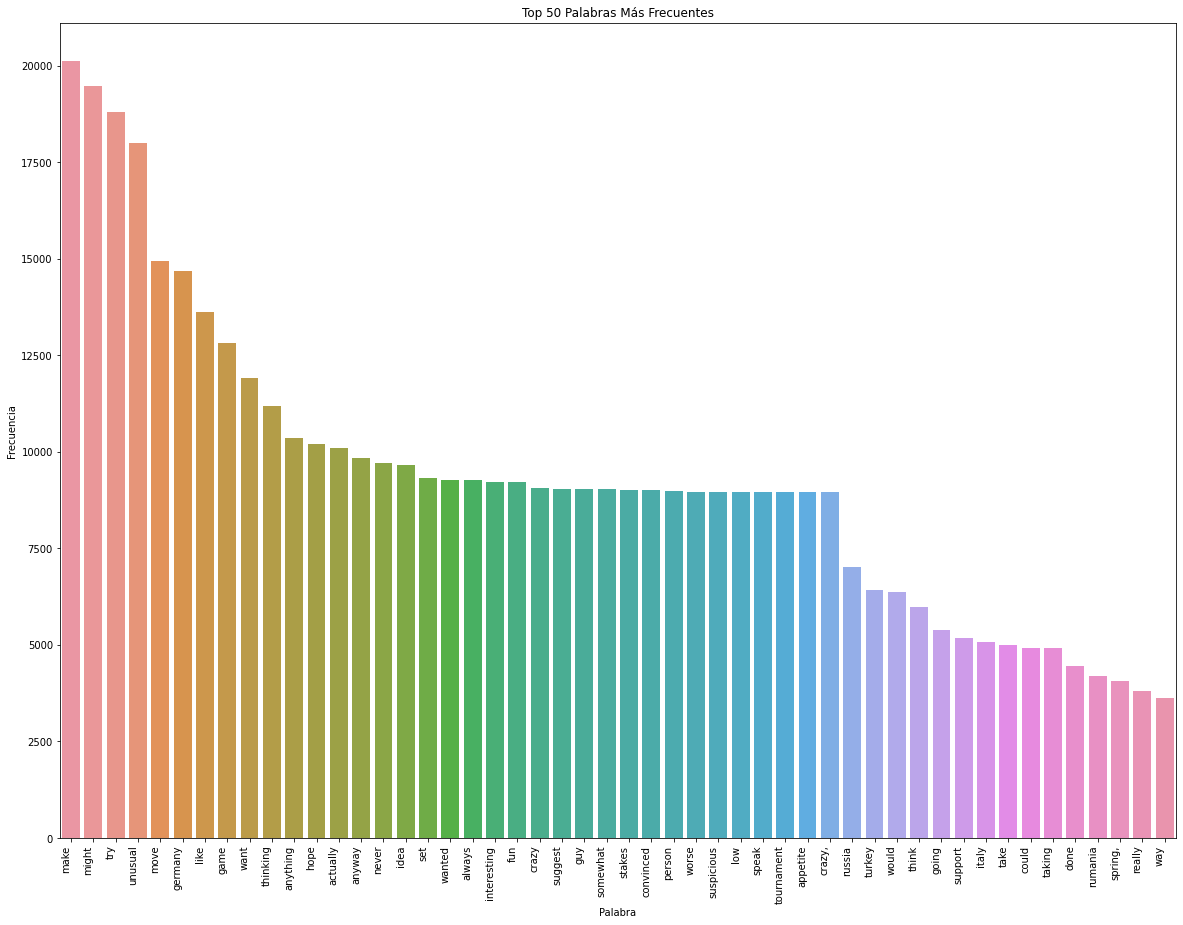

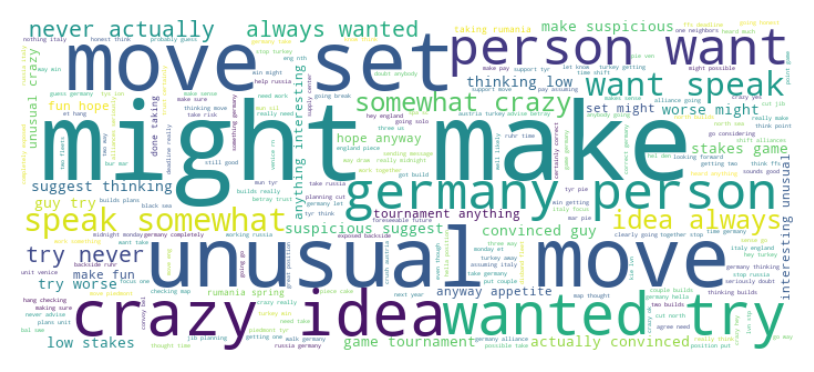

In [53]:
plot_top_words_frequency(df_tfidf, 'summary_more_similar')
generate_wordcloud(df_tfidf, 'summary_more_similar')
plot_top_words_frequency(df_tfidf, 'summary_less_similar')
generate_wordcloud(df_tfidf, 'summary_less_similar')

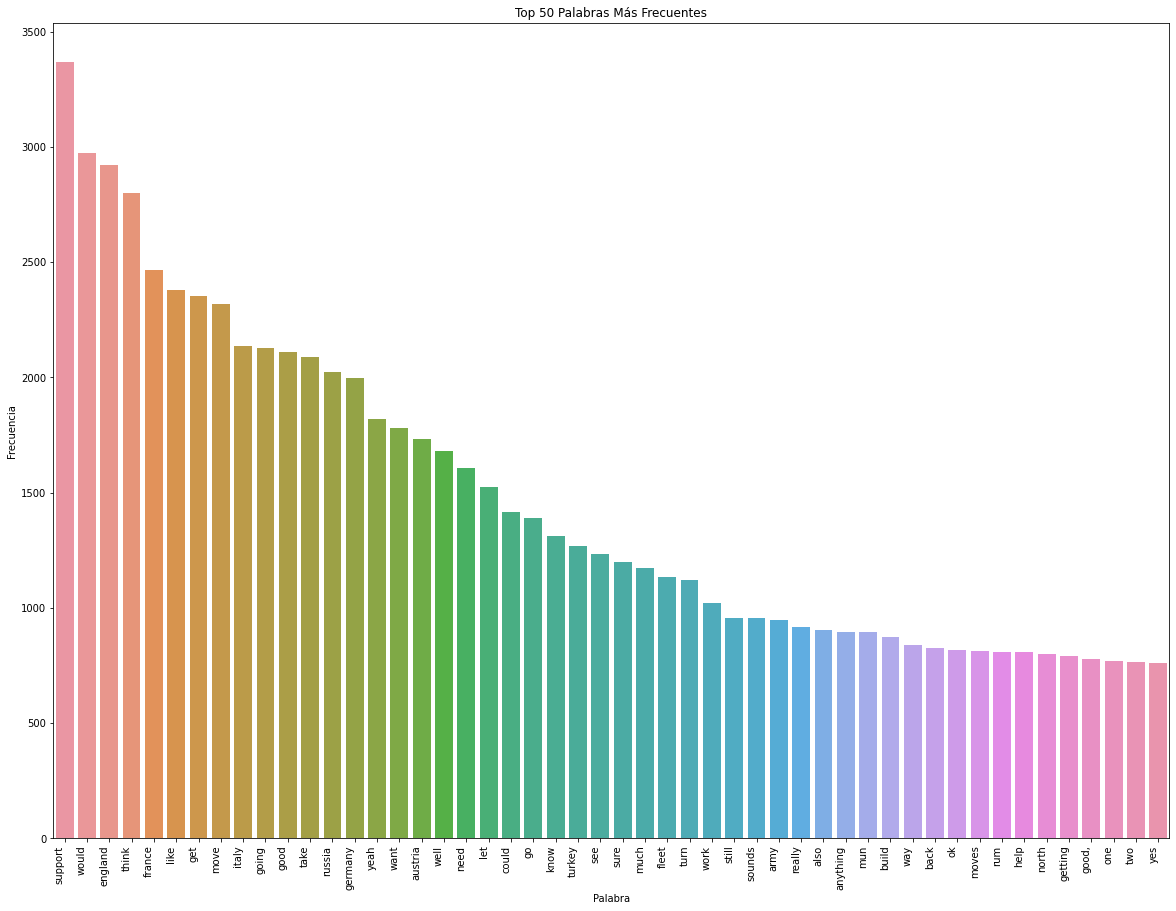

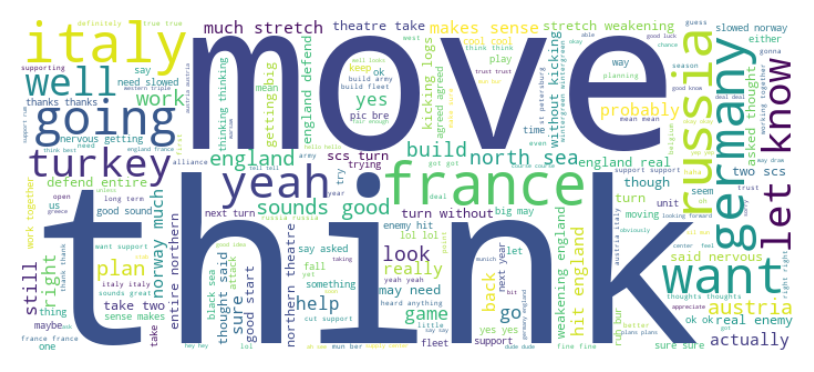

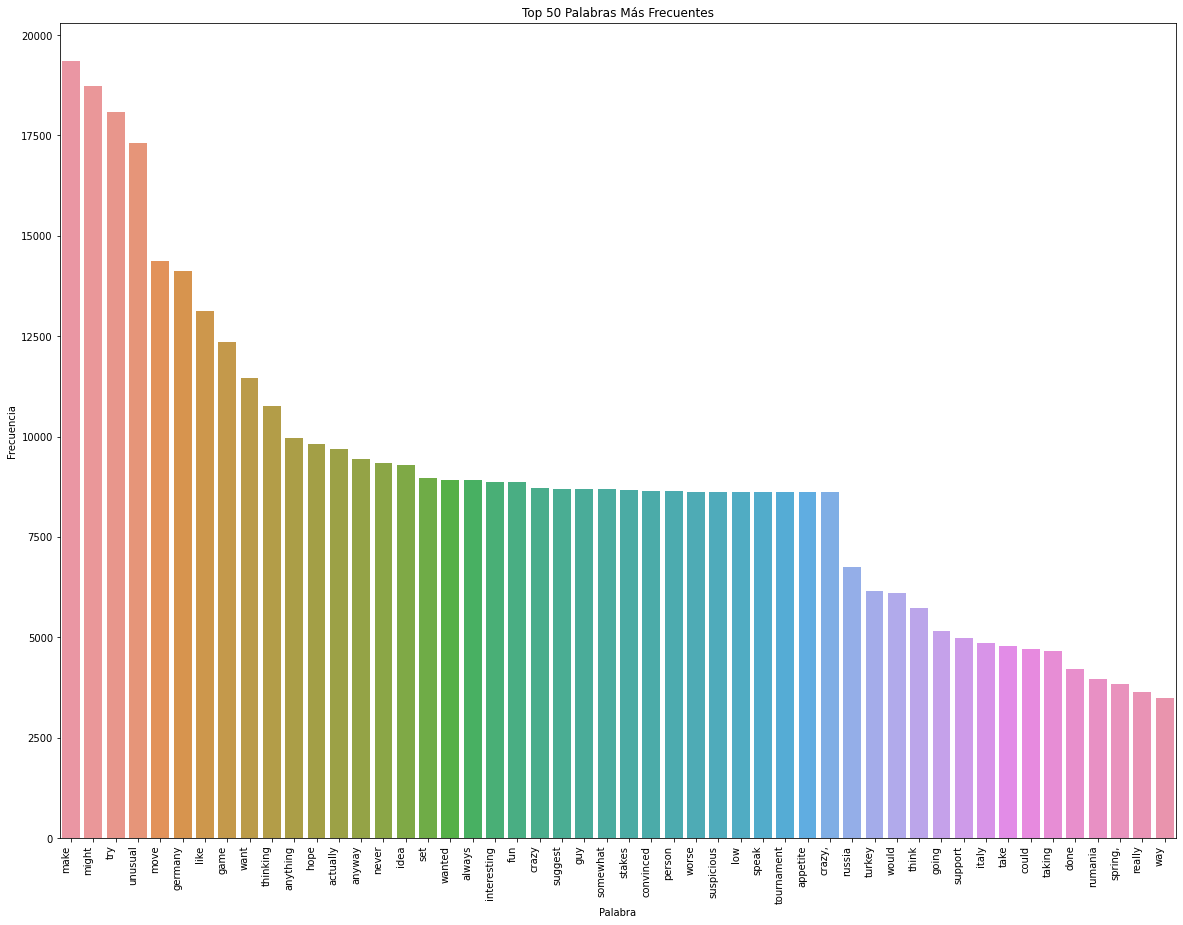

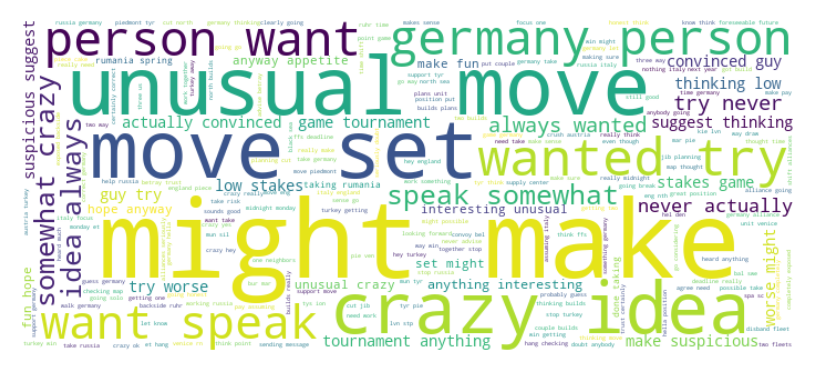

In [54]:
filtered_True = df_tfidf[(df_tfidf['sender_labels'] == True)]

plot_top_words_frequency(filtered_True, 'summary_more_similar')
generate_wordcloud(filtered_True, 'summary_more_similar')

plot_top_words_frequency(filtered_True, 'summary_less_similar')
generate_wordcloud(filtered_True, 'summary_less_similar')

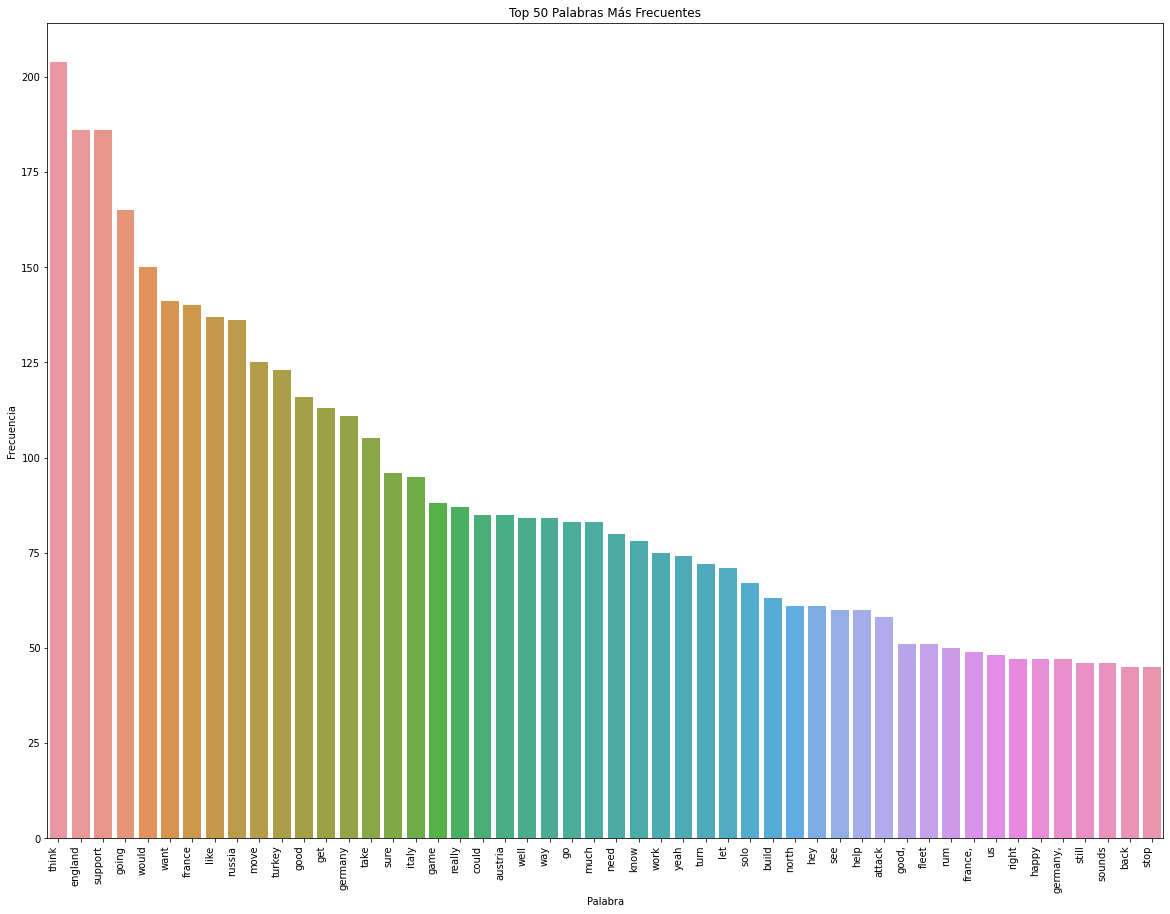

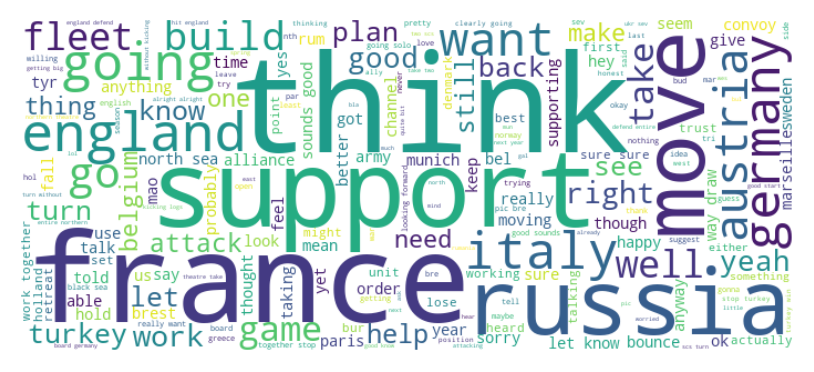

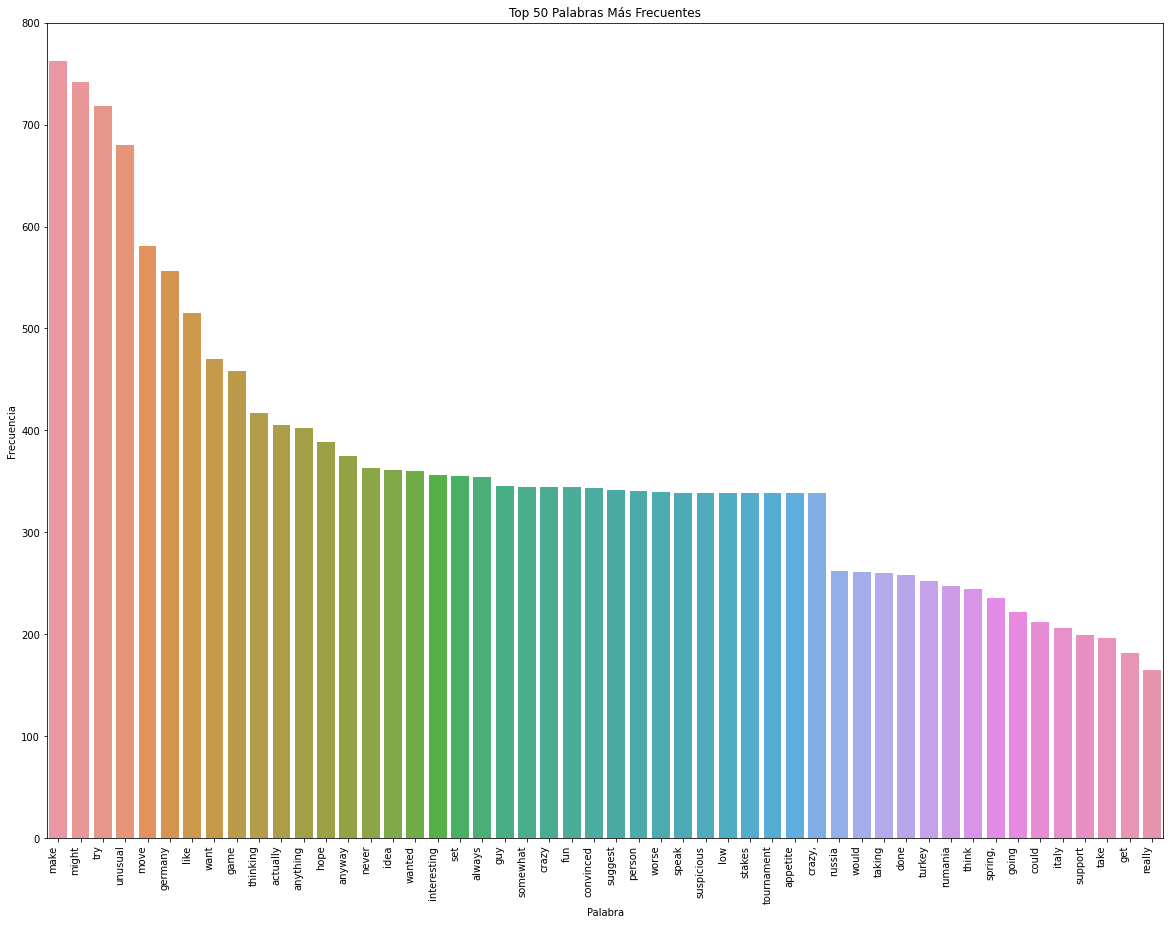

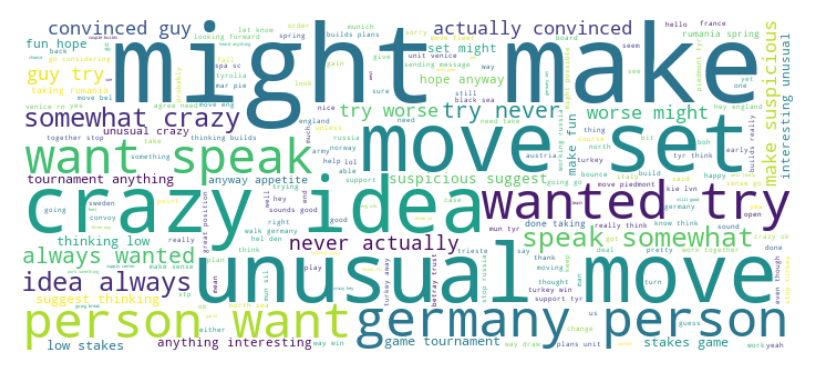

In [55]:
filtered_df = df_tfidf[(df_tfidf['sender_labels'] == False)]

plot_top_words_frequency(filtered_df, 'summary_more_similar')
generate_wordcloud(filtered_df, 'summary_more_similar')

plot_top_words_frequency(filtered_df, 'summary_less_similar')
generate_wordcloud(filtered_df, 'summary_less_similar')

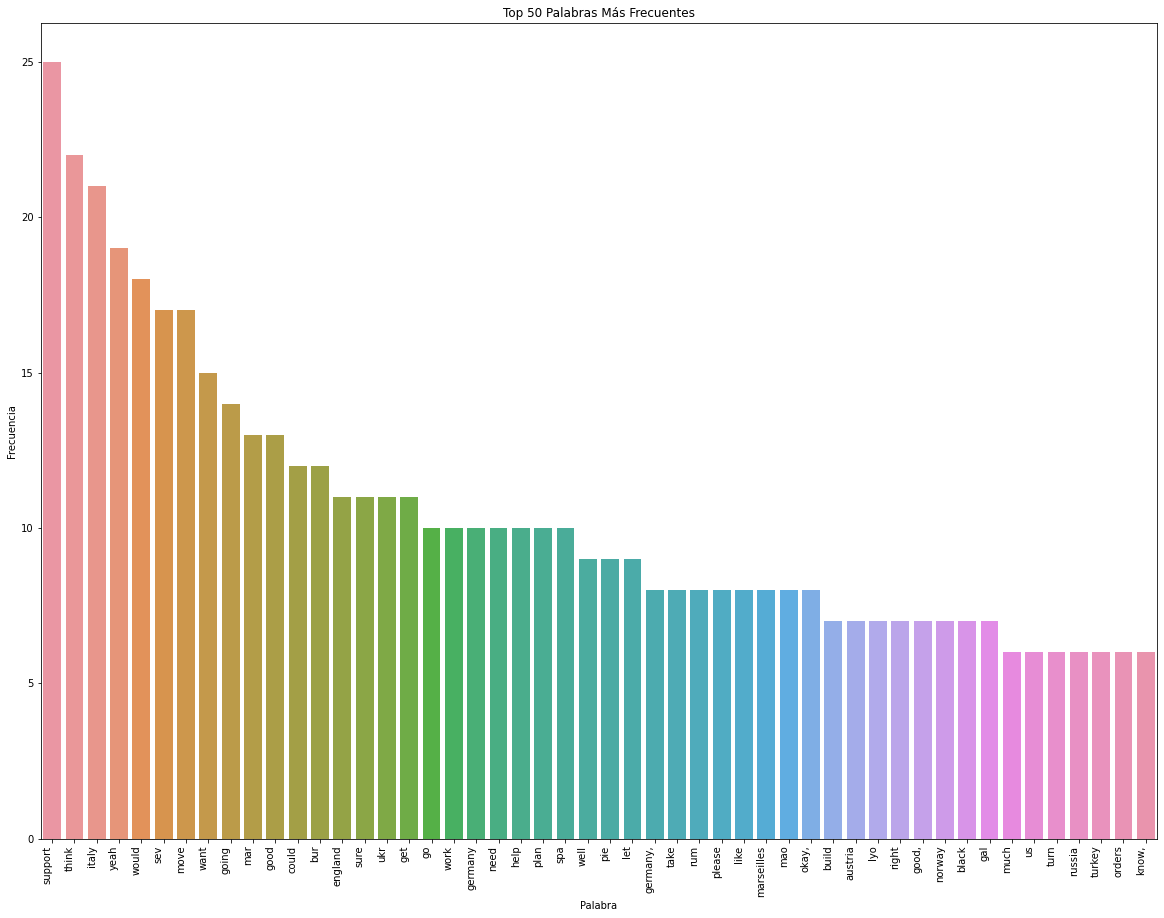

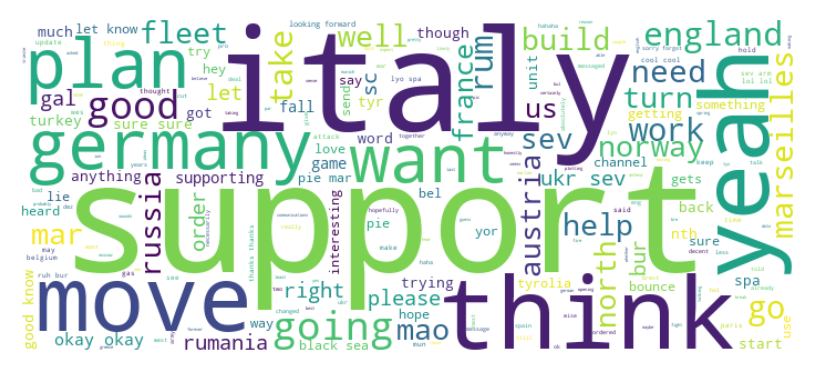

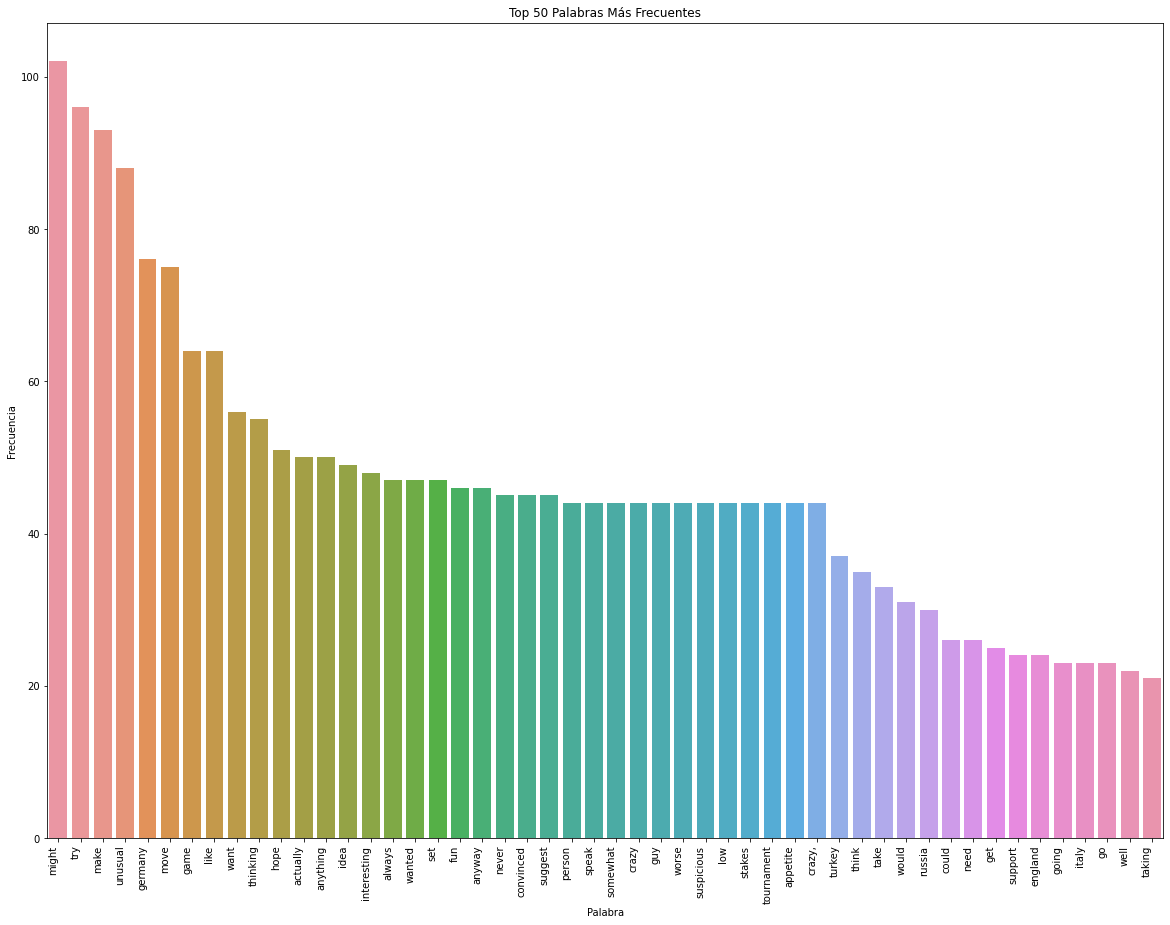

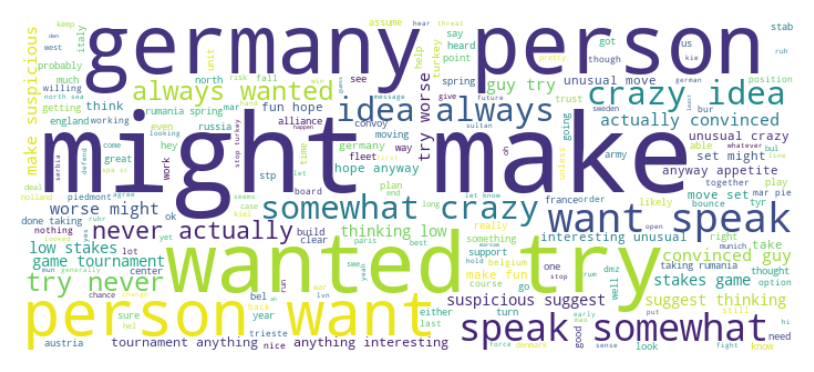

In [56]:
filtered_df = df_tfidf[(df_tfidf['sender_labels'] == False) & (df_tfidf['receiver_labels'] == False)]

# Uso de la función con tu DataFrame y columna específica
plot_top_words_frequency(filtered_df, 'summary_more_similar')
generate_wordcloud(filtered_df, 'summary_more_similar')

plot_top_words_frequency(filtered_df, 'summary_less_similar')
generate_wordcloud(filtered_df, 'summary_less_similar')

In [ ]:
# Despues de el ejercicio anterior de validad las palabras con mayor similaridad, no se nota solo por palabras
# una diferenciacion clara entre las mentiras y las verdades, se refuerza el uso del filtro

In [57]:
filtered_S, num_rows = filter_and_count_keywords(filtered_True,['support', 'would', 'think', 'like'])
print("Number of Rows with Keywords:", num_rows)
filtered_S.head()


Number of Rows with Keywords: 80


messages sender_labels  \
334  Okay. Cool! Do you mind if I take Greece this ...          True   
400  So, This one seems easy. I’ll support you to A...          True   
422                     My units are at your disposal.          True   
501  Hi friend: can you please NOT support England ...          True   
683  From France: "I can stop Italy this turn by th...          True   

    receiver_labels speakers receivers absolute_message_index  \
334            True    italy   austria                    370   
400    NOANNOTATION    italy   austria                    815   
422            True    italy   austria                   1243   
501            True    italy    russia                    540   
683            True  england     italy                   1267   

    relative_message_index seasons years game_score game_score_delta  \
334                     13  Spring  1902          4               -1   
400                     79  Spring  1904          6                0   
422                    101    Fall  1905          7                0   
501                     25    Fall  1902          4               -1   
683                    120    Fall  1905          5               -2   

              players  game_id  caracteres_texto  coincide  \
334  [italy, austria]        1               214      True   
400  [italy, austria]        1               198     False   
422  [italy, austria]        1                14      True   
501   [italy, russia]        1               118      True   
683  [italy, england]        1               466      True   

                                        messages_clean  \
334  okay cool mind take greece year take bulgaria ...   
400  one seems easy support ankara guaranteed eithe...   
422                                     units disposal   
501  hi friend please support england denmark think...   
683  france stop italy turn way pretty easy since i...   

                                                 tfidf  \
334  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
400  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
422  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
501  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
683  [0.0, 0.13325743374986215, 0.0, 0.0, 0.0, 0.0,...   

                                               summary  \
334  great convoy tunis greece support move would g...   
400  gal bud bud ser ser bul gre ser bul latter suc...   
422  take den back three units, would help would gi...   
501  yes let thing friend de, really think importan...   
683  hi germany certainly consider though note trad...   

                                  summary_more_similar  \
334  great convoy tunis greece support move would g...   
400  gal bud bud ser ser bul gre ser bul latter suc...   
422  take den back three units, would help would gi...   
501  yes let thing friend de, really think importan...   
683  hi germany certainly consider though note trad...   

                                  summary_less_similar  
334  germany person want speak somewhat crazy idea ...  
400  germany person want speak somewhat crazy idea ...  
422  germany person want speak somewhat crazy idea ...  
501  done taking rumania spring, tks btw hehe, morn...  
683  deals, trying talk attacking, talked austria, ...

In [58]:
# Revisión de efecto de la limpieza del texto de las publicaciones
prueba = filtered_dfb.sample()
print('Publicación:', prueba.iloc[0]['messages'])
print('Texto limpio:', prueba.iloc[0]['messages_clean'])

Publicación: And it’s game over
Texto limpio: game


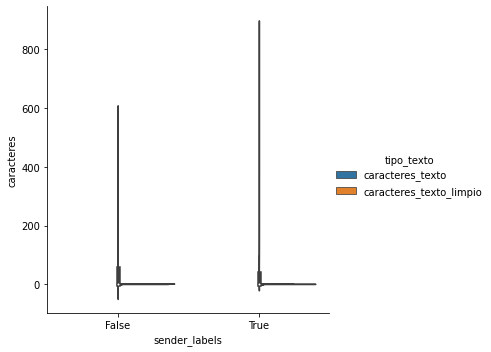

In [59]:
# Crear columna con cantidad de caracteres en la publicación y otra columna con la cantidad de caracteres del texto limpio
df_explode_cleaned['messages_clean'] = df_explode_cleaned.apply(lambda row: len(row.messages), axis = 1)
df_explode_cleaned['caracteres_texto_limpio'] = df_explode_cleaned.apply(lambda row: len(str(row.messages_clean)), axis = 1)

# Graficar cantidad de caracteres en publicaciones según sentimiento después de limpiar el texto de las publicaciones
df_explode_cleaned_aux = df_explode_cleaned.melt(id_vars =['sender_labels'],
                     value_vars =['caracteres_texto', 'caracteres_texto_limpio'],
                     var_name ='tipo_texto',
                     value_name ='caracteres')

sns.catplot(data=df_explode_cleaned_aux, x="sender_labels", y="caracteres", hue="tipo_texto", kind="violin", split=True);

## CONCLUSIONES RELEVANTES

* Debido a las dificultades que puede traer el balanceo de clases con estrategias como SMOTE,
ademas de que es muy costoso computacionalmente y se esta desarrollando en un pc personal este ejercicio, se decide explorar de acuerdo a las conclusiones anteriores, implementar un filtro de tal manera que con reglas duras se pueda mejorar la proporcion de las clases sin necesidad de agregar informacion, teniendo en cuenta que, el ejercicio en cuestion de que se quiere entrenar un modelo de tal manera que detecte mentiras, se van a tomar todos los casos de mentiras asi como los casos de desconfianza, adicionalmente para filtrar los casos verdaderos se toma un filtro de que la cantidad de caracteres sea igual o menor a 20 ya que es la cantidad de caracteres que concentran al rededor de 4000 mensajes, por lo que se considera un buen input para entrenar un modelo

* En este PMV como primera iteracion, y teniendo encuenta las condiciones de que se esta resolviendo el ejercicio en una maquina local, se deja como input para la experimentacion con modelos el filtro anterior, ya que por palabras relevantes no es suficiente para sacar conclusiones, adicionalmente,
a pesar de que se hizo un pequeno acercamiento con NER, se deja este enfoque para un futuro incremental